In [2]:
# импортируем: 
import pandas as pd #  библиотеку для чтения данных
import numpy as np # линейная алгебра

from sklearn.model_selection import train_test_split # разбивку выборки

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

from sklearn import preprocessing  
label_encoder = preprocessing.LabelEncoder() # для бинарных переменных
from sklearn.preprocessing import OneHotEncoder # аналого дамми переменных. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.
from sklearn.preprocessing import StandardScaler # стандартизация данных

from sklearn.linear_model import LogisticRegression # импортируем подходящую для задачи модель логистической регрессии
from sklearn.metrics import confusion_matrix # импортируем конфузную матрицу, как метрику для оценки модели 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score # импортируем метрики оценки модели

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV # импорт автоматического поиска лучших параметров модели

def print_logisitc_metrics(y_true, y_pred): # функция печати метрик accuracy и f1
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')
    
    
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

In [4]:
#df = pd.read_csv('train_0.csv') # считываем данные с выгрузки данные с платформы более не нужны
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv') # сюда нужно записать контрольные предсказаничя модели

In [5]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [7]:
# Посмотрим сколько записей содержит набор данных для моделирования
df.shape[0] # 110148

110148

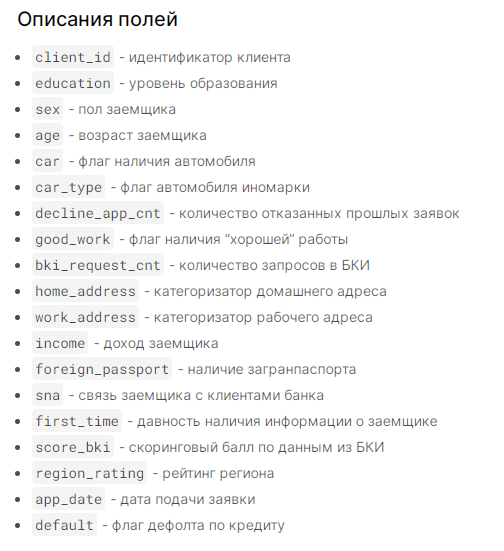

In [10]:
df.nunique(dropna=False) # оценим из какого количества уникальных значений состоят данные по колонкам

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

<AxesSubplot:>

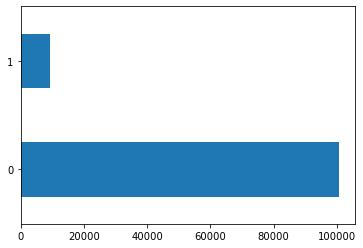

In [12]:
# построим диаграмму для переменной default. Каких клиентов у банка больше?
df.default.value_counts().plot.barh()
# количество клиентов без дефолта многократно больше, чем совершивших дефолт
# вывод - выборка несбалансирована, что негативно влияет на обучение модели

In [13]:
# Посмотрим на тип данных и наличие пропусков:
df.info()
# видим пропуски в данных об образовании клиентов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
# посмотрим распределение данных в колонке образование
df.education.value_counts()
# result = train['state'].fillna(train['state'].value_counts([0]))

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [15]:
# заполним пропуски наиболее частым и доступным каждому школьным образованием
df.education.fillna(df.education.value_counts().index[0], inplace = True)


In [16]:
# проверяем успешность увеличения количества людей со школьным образованием в выборке
df.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Построим графики распределения логарифмированных переменных.

D:\DataSientist\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


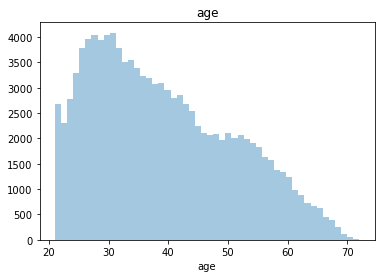

D:\DataSientist\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


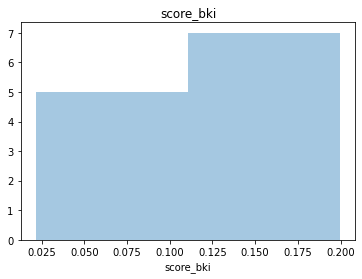

D:\DataSientist\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


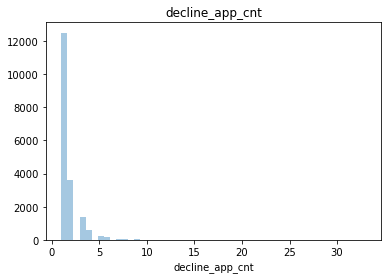

D:\DataSientist\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


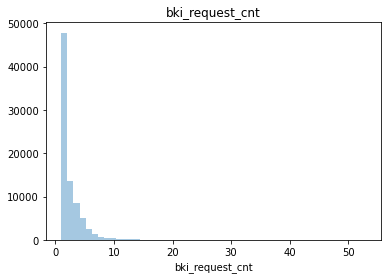

D:\DataSientist\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


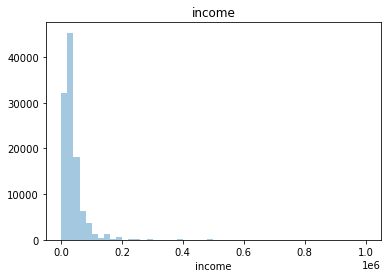

In [17]:
# определим бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#определим категориальные переменные
# первая версия данных cat_cols = ['education', 'work_address', 'home_address']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']

#определим числовые переменные

# первая версия данных num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']

# строим графики
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [30]:
# видим выбросы по количеству отказанных прошлых заявок decline_app_cnt, ограничим все заявки более 5 шт как равные 5
for i in range(len(df.decline_app_cnt)):
    if  df.decline_app_cnt[i] > 5:
        df.decline_app_cnt[i] = 5

0 0
1 5
2 0
3 0
4 0
5 0
6 3
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 1
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 1
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 1
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 2
56 1
57 0
58 0
59 1
60 0
61 0
62 0
63 0
64 2
65 0
66 1
67 0
68 1
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 1
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 1
98 1
99 1
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 1
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 1
121 0
122 0
123 1
124 0
125 0
126 0
127 0
128 0
129 0
130 1
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 1
142 0
143 0
144 3
145 0
146 1
147 0
148 0
149 0
150 1
151 1
152 0
153 0
154 0
155 0
156 6


<ipython-input-30-84dc6ecc4c6b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.decline_app_cnt[i] = 5


157 6
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 3
168 0
169 0
170 0
171 0
172 0
173 1
174 2
175 0
176 0
177 0
178 0
179 1
180 0
181 0
182 0
183 1
184 3
185 0
186 0
187 0
188 0
189 0
190 0
191 0
192 0
193 0
194 0
195 1
196 0
197 0
198 0
199 0
200 0
201 0
202 0
203 0
204 1
205 0
206 1
207 0
208 0
209 0
210 0
211 0
212 0
213 4
214 0
215 0
216 0
217 0
218 0
219 0
220 0
221 0
222 0
223 1
224 0
225 0
226 1
227 0
228 0
229 0
230 0
231 0
232 0
233 0
234 0
235 0
236 0
237 0
238 0
239 0
240 0
241 0
242 0
243 0
244 0
245 3
246 0
247 1
248 1
249 0
250 3
251 0
252 0
253 1
254 0
255 0
256 0
257 0
258 0
259 1
260 1
261 2
262 0
263 0
264 0
265 0
266 0
267 1
268 0
269 0
270 0
271 2
272 0
273 0
274 0
275 0
276 0
277 0
278 0
279 0
280 0
281 0
282 0
283 0
284 0
285 2
286 0
287 0
288 0
289 0
290 4
291 0
292 0
293 0
294 0
295 0
296 0
297 0
298 0
299 2
300 0
301 0
302 0
303 0
304 1
305 0
306 1
307 0
308 0
309 0
310 0
311 0
312 0
313 1
314 0
315 1
316 0
317 0
318 1
319 0
320 0
321 0
322 1
323 

2295 0
2296 0
2297 2
2298 0
2299 0
2300 0
2301 0
2302 0
2303 0
2304 0
2305 0
2306 0
2307 0
2308 1
2309 0
2310 0
2311 1
2312 5
2313 0
2314 0
2315 0
2316 0
2317 1
2318 0
2319 0
2320 1
2321 0
2322 0
2323 0
2324 0
2325 0
2326 0
2327 0
2328 2
2329 0
2330 0
2331 3
2332 0
2333 0
2334 0
2335 0
2336 0
2337 0
2338 0
2339 0
2340 0
2341 1
2342 0
2343 0
2344 0
2345 0
2346 0
2347 1
2348 2
2349 0
2350 0
2351 0
2352 1
2353 0
2354 0
2355 0
2356 0
2357 0
2358 0
2359 0
2360 0
2361 0
2362 0
2363 0
2364 0
2365 0
2366 0
2367 0
2368 0
2369 0
2370 2
2371 0
2372 0
2373 0
2374 0
2375 0
2376 0
2377 1
2378 1
2379 0
2380 2
2381 0
2382 0
2383 0
2384 0
2385 0
2386 0
2387 0
2388 2
2389 0
2390 0
2391 0
2392 0
2393 0
2394 0
2395 1
2396 0
2397 0
2398 1
2399 0
2400 0
2401 1
2402 1
2403 0
2404 1
2405 0
2406 0
2407 0
2408 2
2409 0
2410 0
2411 0
2412 0
2413 1
2414 0
2415 0
2416 0
2417 8
2418 0
2419 0
2420 0
2421 0
2422 1
2423 0
2424 0
2425 0
2426 1
2427 0
2428 0
2429 0
2430 0
2431 0
2432 0
2433 0
2434 0
2435 0
2436 0
2437 0

3544 0
3545 0
3546 0
3547 0
3548 1
3549 1
3550 0
3551 0
3552 2
3553 0
3554 0
3555 0
3556 0
3557 0
3558 0
3559 1
3560 0
3561 0
3562 1
3563 0
3564 0
3565 0
3566 0
3567 0
3568 0
3569 1
3570 0
3571 0
3572 0
3573 0
3574 0
3575 0
3576 0
3577 0
3578 1
3579 0
3580 0
3581 0
3582 0
3583 2
3584 0
3585 0
3586 0
3587 0
3588 0
3589 0
3590 0
3591 0
3592 0
3593 0
3594 0
3595 0
3596 0
3597 1
3598 0
3599 0
3600 0
3601 0
3602 0
3603 0
3604 0
3605 0
3606 0
3607 0
3608 1
3609 0
3610 0
3611 0
3612 0
3613 0
3614 0
3615 0
3616 0
3617 0
3618 0
3619 0
3620 0
3621 0
3622 0
3623 1
3624 0
3625 0
3626 0
3627 1
3628 0
3629 2
3630 0
3631 0
3632 0
3633 0
3634 0
3635 0
3636 3
3637 0
3638 0
3639 0
3640 0
3641 0
3642 0
3643 0
3644 1
3645 0
3646 0
3647 0
3648 0
3649 0
3650 0
3651 0
3652 0
3653 0
3654 0
3655 0
3656 0
3657 0
3658 0
3659 3
3660 0
3661 0
3662 0
3663 0
3664 0
3665 0
3666 1
3667 0
3668 0
3669 0
3670 0
3671 0
3672 2
3673 0
3674 0
3675 1
3676 0
3677 0
3678 0
3679 0
3680 0
3681 0
3682 0
3683 0
3684 0
3685 0
3686 0

5794 0
5795 0
5796 0
5797 4
5798 0
5799 1
5800 0
5801 0
5802 0
5803 0
5804 0
5805 0
5806 0
5807 0
5808 0
5809 0
5810 0
5811 0
5812 0
5813 2
5814 0
5815 0
5816 0
5817 1
5818 0
5819 0
5820 0
5821 1
5822 0
5823 0
5824 0
5825 0
5826 0
5827 0
5828 0
5829 0
5830 0
5831 0
5832 0
5833 0
5834 0
5835 1
5836 2
5837 0
5838 0
5839 0
5840 0
5841 0
5842 0
5843 0
5844 0
5845 0
5846 0
5847 0
5848 0
5849 0
5850 0
5851 0
5852 1
5853 1
5854 0
5855 0
5856 0
5857 0
5858 0
5859 0
5860 1
5861 0
5862 0
5863 0
5864 0
5865 0
5866 0
5867 0
5868 0
5869 0
5870 0
5871 0
5872 0
5873 2
5874 0
5875 0
5876 0
5877 0
5878 0
5879 0
5880 0
5881 0
5882 1
5883 1
5884 0
5885 0
5886 0
5887 0
5888 0
5889 0
5890 2
5891 0
5892 0
5893 0
5894 0
5895 0
5896 0
5897 0
5898 0
5899 3
5900 3
5901 0
5902 1
5903 0
5904 1
5905 0
5906 2
5907 1
5908 2
5909 0
5910 0
5911 0
5912 0
5913 0
5914 0
5915 0
5916 0
5917 0
5918 0
5919 0
5920 0
5921 0
5922 0
5923 1
5924 0
5925 0
5926 0
5927 0
5928 0
5929 0
5930 0
5931 0
5932 0
5933 0
5934 2
5935 0
5936 1

7044 0
7045 1
7046 0
7047 0
7048 1
7049 0
7050 0
7051 0
7052 0
7053 0
7054 1
7055 0
7056 0
7057 0
7058 0
7059 0
7060 0
7061 0
7062 0
7063 0
7064 0
7065 1
7066 0
7067 0
7068 0
7069 0
7070 0
7071 0
7072 0
7073 0
7074 0
7075 0
7076 0
7077 0
7078 0
7079 0
7080 0
7081 0
7082 0
7083 0
7084 0
7085 1
7086 0
7087 0
7088 0
7089 0
7090 0
7091 0
7092 0
7093 0
7094 0
7095 0
7096 0
7097 2
7098 0
7099 1
7100 0
7101 0
7102 0
7103 0
7104 0
7105 0
7106 0
7107 2
7108 0
7109 0
7110 0
7111 0
7112 0
7113 0
7114 0
7115 1
7116 0
7117 0
7118 0
7119 0
7120 0
7121 0
7122 0
7123 0
7124 0
7125 0
7126 0
7127 0
7128 0
7129 0
7130 1
7131 0
7132 0
7133 1
7134 2
7135 0
7136 0
7137 0
7138 0
7139 0
7140 0
7141 0
7142 0
7143 0
7144 1
7145 0
7146 0
7147 0
7148 0
7149 0
7150 0
7151 0
7152 0
7153 0
7154 1
7155 0
7156 0
7157 2
7158 0
7159 0
7160 0
7161 0
7162 0
7163 0
7164 1
7165 1
7166 1
7167 0
7168 1
7169 0
7170 1
7171 0
7172 0
7173 0
7174 0
7175 0
7176 0
7177 0
7178 0
7179 0
7180 0
7181 2
7182 0
7183 0
7184 0
7185 0
7186 0

8293 1
8294 3
8295 0
8296 0
8297 0
8298 1
8299 0
8300 0
8301 0
8302 1
8303 0
8304 1
8305 6
8306 0
8307 0
8308 0
8309 1
8310 0
8311 1
8312 0
8313 0
8314 0
8315 0
8316 0
8317 0
8318 0
8319 0
8320 0
8321 1
8322 0
8323 0
8324 0
8325 0
8326 0
8327 2
8328 0
8329 0
8330 1
8331 0
8332 0
8333 1
8334 0
8335 0
8336 0
8337 0
8338 0
8339 0
8340 0
8341 0
8342 1
8343 0
8344 0
8345 0
8346 0
8347 0
8348 0
8349 0
8350 0
8351 0
8352 2
8353 0
8354 0
8355 0
8356 0
8357 0
8358 0
8359 0
8360 0
8361 0
8362 1
8363 0
8364 0
8365 0
8366 0
8367 0
8368 0
8369 0
8370 2
8371 0
8372 0
8373 0
8374 0
8375 0
8376 0
8377 0
8378 0
8379 0
8380 0
8381 0
8382 0
8383 0
8384 1
8385 2
8386 0
8387 0
8388 0
8389 0
8390 0
8391 0
8392 0
8393 0
8394 0
8395 0
8396 1
8397 0
8398 0
8399 1
8400 1
8401 0
8402 1
8403 0
8404 0
8405 0
8406 0
8407 1
8408 0
8409 0
8410 0
8411 0
8412 0
8413 0
8414 0
8415 0
8416 0
8417 0
8418 0
8419 2
8420 0
8421 2
8422 0
8423 1
8424 0
8425 0
8426 2
8427 1
8428 0
8429 0
8430 0
8431 2
8432 0
8433 0
8434 0
8435 0

10543 0
10544 0
10545 0
10546 0
10547 0
10548 0
10549 0
10550 0
10551 0
10552 0
10553 6
10554 0
10555 1
10556 0
10557 0
10558 0
10559 0
10560 0
10561 0
10562 0
10563 0
10564 0
10565 1
10566 0
10567 0
10568 1
10569 0
10570 0
10571 0
10572 0
10573 1
10574 0
10575 0
10576 0
10577 1
10578 0
10579 0
10580 0
10581 1
10582 0
10583 0
10584 9
10585 2
10586 0
10587 0
10588 0
10589 0
10590 0
10591 0
10592 1
10593 0
10594 0
10595 14
10596 0
10597 1
10598 0
10599 0
10600 0
10601 0
10602 0
10603 0
10604 0
10605 0
10606 0
10607 0
10608 1
10609 0
10610 0
10611 1
10612 0
10613 0
10614 0
10615 0
10616 1
10617 0
10618 0
10619 0
10620 0
10621 0
10622 3
10623 0
10624 0
10625 0
10626 0
10627 0
10628 3
10629 0
10630 0
10631 0
10632 0
10633 0
10634 1
10635 0
10636 1
10637 0
10638 0
10639 0
10640 0
10641 0
10642 0
10643 0
10644 0
10645 0
10646 0
10647 0
10648 0
10649 0
10650 0
10651 0
10652 0
10653 0
10654 0
10655 0
10656 0
10657 1
10658 0
10659 0
10660 0
10661 0
10662 0
10663 0
10664 0
10665 0
10666 0
10667 0

11640 1
11641 0
11642 0
11643 0
11644 0
11645 0
11646 0
11647 0
11648 0
11649 3
11650 0
11651 0
11652 0
11653 0
11654 0
11655 0
11656 0
11657 0
11658 1
11659 0
11660 0
11661 3
11662 0
11663 0
11664 0
11665 1
11666 0
11667 0
11668 0
11669 0
11670 1
11671 0
11672 0
11673 0
11674 0
11675 1
11676 0
11677 3
11678 0
11679 0
11680 1
11681 0
11682 1
11683 1
11684 0
11685 0
11686 3
11687 0
11688 0
11689 0
11690 0
11691 1
11692 0
11693 0
11694 0
11695 0
11696 0
11697 0
11698 0
11699 0
11700 0
11701 0
11702 0
11703 1
11704 0
11705 0
11706 0
11707 0
11708 0
11709 0
11710 0
11711 0
11712 0
11713 0
11714 0
11715 0
11716 1
11717 0
11718 0
11719 2
11720 0
11721 0
11722 1
11723 0
11724 0
11725 0
11726 0
11727 0
11728 1
11729 0
11730 0
11731 0
11732 1
11733 0
11734 0
11735 0
11736 1
11737 0
11738 1
11739 0
11740 0
11741 1
11742 1
11743 0
11744 0
11745 0
11746 0
11747 0
11748 0
11749 0
11750 0
11751 0
11752 0
11753 0
11754 0
11755 0
11756 0
11757 1
11758 0
11759 0
11760 0
11761 0
11762 0
11763 1
11764 0


12807 0
12808 1
12809 3
12810 0
12811 0
12812 0
12813 1
12814 0
12815 0
12816 0
12817 0
12818 0
12819 0
12820 0
12821 0
12822 0
12823 0
12824 0
12825 3
12826 0
12827 0
12828 0
12829 1
12830 0
12831 1
12832 0
12833 0
12834 0
12835 1
12836 0
12837 0
12838 0
12839 1
12840 0
12841 0
12842 1
12843 0
12844 2
12845 0
12846 0
12847 0
12848 0
12849 1
12850 0
12851 0
12852 0
12853 0
12854 0
12855 0
12856 1
12857 0
12858 0
12859 0
12860 0
12861 1
12862 0
12863 0
12864 0
12865 1
12866 0
12867 0
12868 0
12869 0
12870 0
12871 0
12872 0
12873 0
12874 0
12875 0
12876 0
12877 0
12878 2
12879 0
12880 0
12881 0
12882 0
12883 0
12884 0
12885 0
12886 0
12887 0
12888 0
12889 4
12890 0
12891 1
12892 0
12893 0
12894 0
12895 1
12896 0
12897 0
12898 0
12899 1
12900 1
12901 0
12902 0
12903 0
12904 0
12905 1
12906 0
12907 0
12908 0
12909 0
12910 0
12911 0
12912 0
12913 0
12914 0
12915 1
12916 0
12917 0
12918 0
12919 0
12920 0
12921 2
12922 0
12923 0
12924 0
12925 0
12926 1
12927 1
12928 0
12929 0
12930 0
12931 1


14656 0
14657 0
14658 0
14659 0
14660 0
14661 0
14662 0
14663 0
14664 0
14665 0
14666 0
14667 0
14668 0
14669 0
14670 0
14671 0
14672 0
14673 0
14674 0
14675 0
14676 2
14677 0
14678 0
14679 0
14680 0
14681 0
14682 0
14683 0
14684 0
14685 0
14686 0
14687 1
14688 1
14689 1
14690 0
14691 0
14692 0
14693 0
14694 0
14695 0
14696 0
14697 1
14698 0
14699 1
14700 0
14701 0
14702 0
14703 0
14704 1
14705 0
14706 0
14707 0
14708 0
14709 0
14710 0
14711 0
14712 0
14713 0
14714 0
14715 0
14716 0
14717 0
14718 0
14719 0
14720 0
14721 0
14722 0
14723 1
14724 0
14725 0
14726 0
14727 0
14728 0
14729 0
14730 0
14731 0
14732 0
14733 0
14734 0
14735 0
14736 0
14737 0
14738 0
14739 0
14740 0
14741 0
14742 0
14743 0
14744 0
14745 0
14746 0
14747 0
14748 0
14749 1
14750 0
14751 0
14752 0
14753 0
14754 0
14755 0
14756 1
14757 0
14758 0
14759 0
14760 0
14761 0
14762 2
14763 0
14764 0
14765 0
14766 0
14767 0
14768 0
14769 0
14770 0
14771 0
14772 0
14773 0
14774 0
14775 3
14776 1
14777 0
14778 0
14779 0
14780 3


15792 0
15793 3
15794 1
15795 0
15796 0
15797 0
15798 1
15799 2
15800 0
15801 0
15802 0
15803 0
15804 0
15805 0
15806 0
15807 0
15808 0
15809 0
15810 1
15811 0
15812 0
15813 0
15814 0
15815 0
15816 0
15817 0
15818 0
15819 0
15820 0
15821 0
15822 0
15823 0
15824 0
15825 1
15826 0
15827 0
15828 0
15829 0
15830 0
15831 0
15832 0
15833 1
15834 0
15835 0
15836 0
15837 0
15838 1
15839 0
15840 0
15841 0
15842 0
15843 0
15844 0
15845 0
15846 0
15847 0
15848 0
15849 0
15850 0
15851 0
15852 0
15853 0
15854 0
15855 1
15856 0
15857 1
15858 0
15859 0
15860 0
15861 0
15862 0
15863 0
15864 0
15865 0
15866 0
15867 0
15868 0
15869 0
15870 0
15871 3
15872 0
15873 1
15874 0
15875 0
15876 0
15877 0
15878 0
15879 0
15880 1
15881 0
15882 0
15883 0
15884 0
15885 0
15886 0
15887 0
15888 0
15889 0
15890 0
15891 0
15892 1
15893 0
15894 0
15895 0
15896 0
15897 1
15898 1
15899 0
15900 0
15901 0
15902 0
15903 1
15904 0
15905 0
15906 0
15907 0
15908 0
15909 0
15910 2
15911 0
15912 0
15913 0
15914 0
15915 0
15916 0


17791 0
17792 0
17793 0
17794 0
17795 0
17796 0
17797 0
17798 1
17799 0
17800 0
17801 0
17802 0
17803 0
17804 0
17805 0
17806 0
17807 0
17808 0
17809 5
17810 0
17811 0
17812 0
17813 0
17814 1
17815 4
17816 0
17817 0
17818 0
17819 0
17820 0
17821 0
17822 0
17823 0
17824 0
17825 0
17826 0
17827 0
17828 0
17829 0
17830 1
17831 0
17832 0
17833 1
17834 0
17835 1
17836 3
17837 1
17838 0
17839 0
17840 0
17841 0
17842 0
17843 0
17844 0
17845 0
17846 0
17847 0
17848 0
17849 0
17850 1
17851 0
17852 0
17853 0
17854 0
17855 0
17856 0
17857 0
17858 0
17859 0
17860 0
17861 2
17862 0
17863 0
17864 0
17865 0
17866 0
17867 0
17868 0
17869 0
17870 0
17871 1
17872 0
17873 0
17874 0
17875 0
17876 0
17877 0
17878 1
17879 0
17880 0
17881 0
17882 5
17883 0
17884 0
17885 0
17886 0
17887 1
17888 0
17889 1
17890 1
17891 1
17892 0
17893 0
17894 0
17895 0
17896 2
17897 0
17898 1
17899 0
17900 0
17901 0
17902 0
17903 1
17904 0
17905 0
17906 0
17907 0
17908 0
17909 0
17910 1
17911 0
17912 0
17913 2
17914 0
17915 0


18830 0
18831 0
18832 0
18833 4
18834 0
18835 0
18836 0
18837 0
18838 0
18839 0
18840 1
18841 0
18842 0
18843 1
18844 0
18845 0
18846 0
18847 0
18848 1
18849 0
18850 5
18851 0
18852 0
18853 0
18854 0
18855 0
18856 0
18857 0
18858 0
18859 0
18860 0
18861 1
18862 0
18863 0
18864 6
18865 0
18866 0
18867 0
18868 0
18869 0
18870 0
18871 0
18872 0
18873 0
18874 0
18875 0
18876 0
18877 0
18878 0
18879 1
18880 0
18881 0
18882 0
18883 0
18884 0
18885 0
18886 0
18887 0
18888 0
18889 0
18890 0
18891 1
18892 0
18893 0
18894 0
18895 0
18896 0
18897 0
18898 0
18899 0
18900 0
18901 0
18902 0
18903 0
18904 0
18905 0
18906 0
18907 0
18908 0
18909 1
18910 1
18911 0
18912 0
18913 0
18914 0
18915 0
18916 0
18917 0
18918 0
18919 0
18920 0
18921 0
18922 0
18923 0
18924 0
18925 0
18926 0
18927 0
18928 0
18929 1
18930 0
18931 0
18932 0
18933 0
18934 0
18935 1
18936 0
18937 0
18938 0
18939 0
18940 2
18941 0
18942 0
18943 1
18944 0
18945 0
18946 1
18947 0
18948 0
18949 1
18950 0
18951 1
18952 0
18953 0
18954 0


20022 0
20023 0
20024 0
20025 1
20026 1
20027 2
20028 0
20029 0
20030 1
20031 0
20032 0
20033 0
20034 0
20035 0
20036 0
20037 0
20038 0
20039 0
20040 0
20041 0
20042 0
20043 0
20044 0
20045 0
20046 0
20047 0
20048 0
20049 0
20050 3
20051 0
20052 0
20053 0
20054 0
20055 0
20056 7
20057 0
20058 0
20059 0
20060 0
20061 0
20062 0
20063 0
20064 0
20065 0
20066 1
20067 0
20068 1
20069 1
20070 1
20071 0
20072 1
20073 0
20074 0
20075 0
20076 0
20077 0
20078 0
20079 0
20080 1
20081 0
20082 1
20083 0
20084 0
20085 1
20086 1
20087 0
20088 0
20089 0
20090 0
20091 0
20092 0
20093 0
20094 0
20095 0
20096 1
20097 0
20098 0
20099 1
20100 1
20101 0
20102 0
20103 0
20104 0
20105 0
20106 0
20107 0
20108 0
20109 0
20110 0
20111 0
20112 3
20113 0
20114 0
20115 0
20116 0
20117 0
20118 0
20119 0
20120 0
20121 0
20122 1
20123 0
20124 0
20125 0
20126 0
20127 0
20128 0
20129 0
20130 0
20131 0
20132 0
20133 1
20134 0
20135 0
20136 0
20137 0
20138 0
20139 0
20140 0
20141 0
20142 0
20143 0
20144 0
20145 0
20146 0


22040 0
22041 0
22042 0
22043 2
22044 0
22045 0
22046 0
22047 0
22048 0
22049 0
22050 0
22051 0
22052 0
22053 0
22054 2
22055 5
22056 0
22057 0
22058 0
22059 0
22060 0
22061 0
22062 0
22063 1
22064 1
22065 0
22066 0
22067 0
22068 0
22069 0
22070 0
22071 1
22072 0
22073 0
22074 4
22075 0
22076 0
22077 0
22078 0
22079 0
22080 0
22081 1
22082 0
22083 2
22084 1
22085 0
22086 0
22087 2
22088 1
22089 0
22090 0
22091 0
22092 0
22093 0
22094 0
22095 0
22096 0
22097 0
22098 0
22099 0
22100 0
22101 0
22102 0
22103 0
22104 0
22105 0
22106 0
22107 2
22108 0
22109 0
22110 0
22111 0
22112 0
22113 0
22114 0
22115 0
22116 0
22117 1
22118 1
22119 0
22120 0
22121 0
22122 0
22123 0
22124 0
22125 2
22126 0
22127 0
22128 0
22129 1
22130 0
22131 0
22132 0
22133 0
22134 0
22135 0
22136 0
22137 0
22138 0
22139 0
22140 0
22141 0
22142 0
22143 0
22144 0
22145 0
22146 0
22147 0
22148 1
22149 0
22150 0
22151 0
22152 0
22153 0
22154 0
22155 0
22156 0
22157 0
22158 0
22159 0
22160 0
22161 0
22162 0
22163 0
22164 0


23290 0
23291 0
23292 0
23293 0
23294 0
23295 0
23296 0
23297 0
23298 0
23299 0
23300 0
23301 0
23302 0
23303 0
23304 0
23305 1
23306 0
23307 0
23308 0
23309 0
23310 0
23311 0
23312 0
23313 0
23314 0
23315 0
23316 0
23317 0
23318 2
23319 1
23320 0
23321 0
23322 0
23323 1
23324 0
23325 0
23326 0
23327 0
23328 0
23329 0
23330 0
23331 0
23332 0
23333 0
23334 0
23335 0
23336 0
23337 1
23338 0
23339 2
23340 0
23341 0
23342 0
23343 0
23344 0
23345 0
23346 0
23347 0
23348 0
23349 0
23350 0
23351 0
23352 1
23353 2
23354 1
23355 0
23356 0
23357 0
23358 1
23359 0
23360 0
23361 0
23362 0
23363 0
23364 0
23365 2
23366 1
23367 0
23368 0
23369 0
23370 0
23371 0
23372 0
23373 0
23374 0
23375 0
23376 0
23377 4
23378 0
23379 0
23380 0
23381 0
23382 0
23383 1
23384 0
23385 0
23386 0
23387 0
23388 0
23389 1
23390 0
23391 0
23392 0
23393 0
23394 0
23395 0
23396 1
23397 0
23398 0
23399 0
23400 0
23401 7
23402 0
23403 1
23404 0
23405 0
23406 0
23407 1
23408 0
23409 0
23410 0
23411 0
23412 0
23413 0
23414 0


25257 0
25258 0
25259 0
25260 0
25261 0
25262 0
25263 0
25264 0
25265 0
25266 2
25267 0
25268 0
25269 0
25270 0
25271 0
25272 0
25273 0
25274 0
25275 0
25276 0
25277 0
25278 0
25279 0
25280 0
25281 0
25282 0
25283 0
25284 0
25285 0
25286 0
25287 0
25288 0
25289 0
25290 0
25291 0
25292 0
25293 0
25294 0
25295 0
25296 1
25297 0
25298 0
25299 0
25300 0
25301 0
25302 0
25303 0
25304 0
25305 0
25306 0
25307 1
25308 1
25309 0
25310 3
25311 1
25312 0
25313 2
25314 0
25315 0
25316 0
25317 0
25318 0
25319 0
25320 0
25321 1
25322 0
25323 0
25324 0
25325 0
25326 0
25327 0
25328 0
25329 0
25330 0
25331 0
25332 0
25333 0
25334 0
25335 0
25336 0
25337 0
25338 0
25339 2
25340 0
25341 0
25342 0
25343 0
25344 0
25345 0
25346 1
25347 0
25348 1
25349 0
25350 0
25351 0
25352 0
25353 0
25354 0
25355 0
25356 0
25357 0
25358 0
25359 1
25360 0
25361 0
25362 0
25363 0
25364 0
25365 1
25366 0
25367 0
25368 0
25369 0
25370 0
25371 0
25372 0
25373 0
25374 2
25375 0
25376 0
25377 0
25378 0
25379 0
25380 1
25381 0


27242 3
27243 0
27244 1
27245 0
27246 0
27247 0
27248 0
27249 0
27250 0
27251 0
27252 1
27253 0
27254 0
27255 0
27256 0
27257 0
27258 0
27259 0
27260 0
27261 0
27262 0
27263 0
27264 0
27265 0
27266 0
27267 0
27268 0
27269 0
27270 0
27271 0
27272 0
27273 0
27274 0
27275 0
27276 0
27277 1
27278 0
27279 1
27280 0
27281 1
27282 0
27283 0
27284 0
27285 1
27286 0
27287 0
27288 0
27289 0
27290 0
27291 0
27292 4
27293 0
27294 0
27295 0
27296 0
27297 0
27298 0
27299 9
27300 1
27301 1
27302 0
27303 0
27304 0
27305 0
27306 0
27307 2
27308 0
27309 0
27310 3
27311 0
27312 0
27313 0
27314 0
27315 0
27316 0
27317 0
27318 0
27319 0
27320 0
27321 0
27322 3
27323 0
27324 0
27325 0
27326 0
27327 0
27328 0
27329 2
27330 0
27331 0
27332 0
27333 0
27334 0
27335 0
27336 0
27337 0
27338 0
27339 0
27340 0
27341 5
27342 0
27343 0
27344 0
27345 0
27346 0
27347 0
27348 0
27349 0
27350 0
27351 0
27352 0
27353 0
27354 1
27355 0
27356 0
27357 0
27358 0
27359 0
27360 1
27361 1
27362 0
27363 0
27364 1
27365 0
27366 0


29209 0
29210 0
29211 0
29212 0
29213 0
29214 0
29215 0
29216 0
29217 0
29218 0
29219 0
29220 1
29221 0
29222 0
29223 0
29224 0
29225 0
29226 0
29227 0
29228 1
29229 0
29230 1
29231 0
29232 1
29233 1
29234 1
29235 0
29236 0
29237 0
29238 0
29239 0
29240 0
29241 0
29242 1
29243 0
29244 0
29245 0
29246 0
29247 0
29248 0
29249 2
29250 3
29251 0
29252 1
29253 0
29254 0
29255 1
29256 0
29257 1
29258 0
29259 0
29260 0
29261 0
29262 0
29263 0
29264 0
29265 0
29266 0
29267 0
29268 0
29269 0
29270 0
29271 0
29272 1
29273 0
29274 0
29275 0
29276 3
29277 0
29278 0
29279 0
29280 0
29281 0
29282 0
29283 0
29284 0
29285 0
29286 0
29287 0
29288 0
29289 1
29290 0
29291 0
29292 0
29293 0
29294 0
29295 0
29296 0
29297 0
29298 0
29299 0
29300 2
29301 0
29302 0
29303 0
29304 0
29305 0
29306 0
29307 0
29308 0
29309 0
29310 3
29311 0
29312 0
29313 0
29314 0
29315 0
29316 0
29317 3
29318 0
29319 0
29320 0
29321 0
29322 0
29323 0
29324 0
29325 1
29326 0
29327 1
29328 1
29329 0
29330 0
29331 3
29332 0
29333 0


30265 0
30266 0
30267 0
30268 0
30269 0
30270 0
30271 0
30272 0
30273 0
30274 1
30275 0
30276 0
30277 0
30278 0
30279 0
30280 0
30281 0
30282 0
30283 0
30284 2
30285 0
30286 0
30287 0
30288 1
30289 0
30290 0
30291 1
30292 0
30293 0
30294 0
30295 0
30296 0
30297 0
30298 0
30299 0
30300 0
30301 0
30302 0
30303 0
30304 4
30305 0
30306 0
30307 0
30308 0
30309 0
30310 0
30311 0
30312 0
30313 0
30314 0
30315 0
30316 2
30317 1
30318 0
30319 0
30320 0
30321 0
30322 0
30323 0
30324 2
30325 4
30326 0
30327 3
30328 0
30329 0
30330 1
30331 4
30332 0
30333 0
30334 4
30335 0
30336 0
30337 0
30338 0
30339 0
30340 0
30341 0
30342 0
30343 0
30344 0
30345 1
30346 0
30347 0
30348 0
30349 1
30350 0
30351 0
30352 0
30353 0
30354 0
30355 0
30356 0
30357 1
30358 0
30359 1
30360 0
30361 0
30362 0
30363 0
30364 0
30365 0
30366 1
30367 0
30368 0
30369 0
30370 0
30371 0
30372 0
30373 1
30374 0
30375 0
30376 12
30377 0
30378 2
30379 1
30380 1
30381 0
30382 0
30383 0
30384 1
30385 1
30386 3
30387 0
30388 0
30389 0

32268 1
32269 0
32270 0
32271 3
32272 0
32273 1
32274 0
32275 1
32276 0
32277 0
32278 1
32279 0
32280 0
32281 0
32282 0
32283 1
32284 0
32285 0
32286 0
32287 0
32288 0
32289 1
32290 1
32291 0
32292 0
32293 3
32294 0
32295 0
32296 0
32297 0
32298 0
32299 0
32300 0
32301 0
32302 0
32303 0
32304 0
32305 0
32306 1
32307 0
32308 0
32309 0
32310 0
32311 0
32312 1
32313 0
32314 0
32315 0
32316 1
32317 1
32318 0
32319 0
32320 0
32321 1
32322 0
32323 4
32324 0
32325 0
32326 0
32327 0
32328 0
32329 0
32330 0
32331 0
32332 0
32333 0
32334 0
32335 0
32336 0
32337 0
32338 0
32339 0
32340 0
32341 0
32342 1
32343 0
32344 0
32345 1
32346 0
32347 0
32348 0
32349 0
32350 0
32351 0
32352 1
32353 0
32354 0
32355 0
32356 4
32357 1
32358 0
32359 0
32360 0
32361 0
32362 0
32363 1
32364 0
32365 0
32366 0
32367 0
32368 0
32369 0
32370 0
32371 0
32372 0
32373 0
32374 1
32375 0
32376 0
32377 0
32378 0
32379 2
32380 0
32381 0
32382 0
32383 0
32384 0
32385 0
32386 1
32387 1
32388 0
32389 0
32390 1
32391 1
32392 0


34352 0
34353 0
34354 0
34355 0
34356 0
34357 1
34358 0
34359 0
34360 0
34361 0
34362 0
34363 0
34364 0
34365 0
34366 0
34367 1
34368 0
34369 0
34370 0
34371 0
34372 0
34373 0
34374 0
34375 0
34376 0
34377 3
34378 0
34379 0
34380 0
34381 0
34382 0
34383 0
34384 0
34385 0
34386 0
34387 0
34388 0
34389 2
34390 1
34391 0
34392 0
34393 0
34394 0
34395 0
34396 0
34397 0
34398 0
34399 0
34400 0
34401 1
34402 0
34403 0
34404 0
34405 0
34406 0
34407 0
34408 0
34409 1
34410 0
34411 0
34412 0
34413 0
34414 0
34415 1
34416 0
34417 1
34418 0
34419 0
34420 0
34421 0
34422 0
34423 0
34424 1
34425 0
34426 0
34427 0
34428 0
34429 0
34430 0
34431 0
34432 0
34433 0
34434 0
34435 0
34436 0
34437 0
34438 0
34439 0
34440 3
34441 0
34442 0
34443 0
34444 0
34445 0
34446 0
34447 0
34448 0
34449 0
34450 0
34451 0
34452 0
34453 0
34454 0
34455 0
34456 0
34457 0
34458 1
34459 0
34460 0
34461 1
34462 0
34463 1
34464 0
34465 0
34466 0
34467 0
34468 0
34469 0
34470 0
34471 0
34472 0
34473 0
34474 1
34475 0
34476 0


35418 0
35419 0
35420 0
35421 0
35422 1
35423 0
35424 1
35425 0
35426 0
35427 0
35428 0
35429 0
35430 0
35431 0
35432 0
35433 0
35434 0
35435 0
35436 0
35437 0
35438 0
35439 0
35440 0
35441 0
35442 0
35443 2
35444 0
35445 0
35446 0
35447 0
35448 0
35449 0
35450 0
35451 0
35452 0
35453 0
35454 0
35455 0
35456 0
35457 0
35458 0
35459 0
35460 0
35461 3
35462 0
35463 0
35464 0
35465 0
35466 0
35467 1
35468 0
35469 0
35470 2
35471 0
35472 1
35473 0
35474 0
35475 0
35476 1
35477 3
35478 0
35479 0
35480 0
35481 2
35482 0
35483 0
35484 4
35485 0
35486 0
35487 0
35488 0
35489 0
35490 0
35491 0
35492 0
35493 0
35494 0
35495 0
35496 0
35497 0
35498 0
35499 0
35500 0
35501 0
35502 0
35503 0
35504 0
35505 0
35506 0
35507 0
35508 0
35509 0
35510 0
35511 0
35512 0
35513 1
35514 0
35515 0
35516 0
35517 0
35518 0
35519 0
35520 0
35521 0
35522 0
35523 0
35524 0
35525 1
35526 0
35527 0
35528 0
35529 0
35530 0
35531 0
35532 0
35533 0
35534 0
35535 0
35536 0
35537 0
35538 0
35539 0
35540 0
35541 0
35542 0


37331 0
37332 0
37333 3
37334 0
37335 0
37336 0
37337 0
37338 0
37339 0
37340 1
37341 0
37342 0
37343 0
37344 0
37345 0
37346 0
37347 0
37348 0
37349 0
37350 0
37351 0
37352 0
37353 0
37354 0
37355 0
37356 0
37357 0
37358 0
37359 0
37360 0
37361 0
37362 0
37363 0
37364 0
37365 0
37366 0
37367 0
37368 0
37369 0
37370 0
37371 0
37372 0
37373 0
37374 0
37375 0
37376 0
37377 0
37378 1
37379 0
37380 0
37381 0
37382 0
37383 0
37384 1
37385 0
37386 1
37387 0
37388 1
37389 0
37390 0
37391 1
37392 0
37393 0
37394 0
37395 0
37396 0
37397 0
37398 0
37399 0
37400 0
37401 0
37402 0
37403 0
37404 0
37405 0
37406 0
37407 1
37408 0
37409 0
37410 0
37411 0
37412 1
37413 0
37414 0
37415 0
37416 0
37417 0
37418 0
37419 0
37420 0
37421 1
37422 1
37423 0
37424 0
37425 0
37426 0
37427 0
37428 0
37429 0
37430 0
37431 2
37432 0
37433 0
37434 0
37435 0
37436 0
37437 0
37438 0
37439 0
37440 0
37441 0
37442 0
37443 0
37444 0
37445 1
37446 0
37447 0
37448 0
37449 4
37450 0
37451 1
37452 1
37453 0
37454 0
37455 0


38536 0
38537 0
38538 0
38539 0
38540 0
38541 0
38542 0
38543 0
38544 0
38545 0
38546 0
38547 0
38548 0
38549 0
38550 0
38551 0
38552 0
38553 0
38554 0
38555 0
38556 0
38557 0
38558 0
38559 0
38560 0
38561 1
38562 0
38563 0
38564 1
38565 1
38566 0
38567 2
38568 0
38569 1
38570 1
38571 0
38572 0
38573 0
38574 0
38575 0
38576 0
38577 0
38578 0
38579 1
38580 0
38581 0
38582 0
38583 0
38584 0
38585 0
38586 0
38587 3
38588 3
38589 0
38590 0
38591 0
38592 0
38593 0
38594 3
38595 0
38596 0
38597 0
38598 0
38599 0
38600 0
38601 0
38602 0
38603 0
38604 0
38605 0
38606 0
38607 0
38608 2
38609 0
38610 0
38611 0
38612 0
38613 0
38614 0
38615 0
38616 1
38617 2
38618 0
38619 0
38620 0
38621 0
38622 0
38623 0
38624 0
38625 0
38626 0
38627 1
38628 0
38629 0
38630 1
38631 0
38632 0
38633 1
38634 0
38635 0
38636 0
38637 0
38638 0
38639 0
38640 0
38641 0
38642 0
38643 0
38644 0
38645 0
38646 1
38647 0
38648 1
38649 0
38650 0
38651 0
38652 1
38653 1
38654 0
38655 0
38656 0
38657 0
38658 0
38659 0
38660 1


39786 0
39787 0
39788 0
39789 0
39790 0
39791 1
39792 0
39793 0
39794 0
39795 0
39796 0
39797 0
39798 0
39799 0
39800 0
39801 0
39802 0
39803 0
39804 0
39805 0
39806 0
39807 0
39808 0
39809 0
39810 0
39811 0
39812 0
39813 0
39814 0
39815 1
39816 0
39817 0
39818 0
39819 3
39820 0
39821 0
39822 0
39823 0
39824 0
39825 0
39826 0
39827 0
39828 1
39829 2
39830 2
39831 0
39832 0
39833 1
39834 0
39835 1
39836 0
39837 0
39838 0
39839 0
39840 0
39841 0
39842 0
39843 5
39844 0
39845 0
39846 0
39847 0
39848 0
39849 0
39850 0
39851 0
39852 0
39853 1
39854 0
39855 2
39856 0
39857 0
39858 0
39859 0
39860 1
39861 0
39862 1
39863 0
39864 0
39865 0
39866 0
39867 0
39868 0
39869 0
39870 0
39871 0
39872 0
39873 0
39874 0
39875 0
39876 0
39877 0
39878 0
39879 0
39880 0
39881 0
39882 0
39883 0
39884 0
39885 0
39886 3
39887 1
39888 0
39889 0
39890 1
39891 0
39892 0
39893 0
39894 0
39895 0
39896 1
39897 0
39898 0
39899 0
39900 0
39901 0
39902 0
39903 0
39904 0
39905 0
39906 0
39907 0
39908 0
39909 0
39910 0


40822 0
40823 4
40824 1
40825 1
40826 0
40827 0
40828 0
40829 3
40830 1
40831 0
40832 0
40833 1
40834 0
40835 0
40836 0
40837 0
40838 1
40839 0
40840 0
40841 0
40842 0
40843 0
40844 0
40845 0
40846 0
40847 0
40848 0
40849 0
40850 0
40851 0
40852 0
40853 0
40854 0
40855 0
40856 0
40857 0
40858 1
40859 0
40860 0
40861 0
40862 0
40863 0
40864 0
40865 0
40866 0
40867 0
40868 1
40869 1
40870 0
40871 0
40872 0
40873 0
40874 0
40875 0
40876 0
40877 0
40878 0
40879 1
40880 0
40881 0
40882 0
40883 0
40884 1
40885 0
40886 0
40887 0
40888 0
40889 1
40890 0
40891 0
40892 0
40893 0
40894 1
40895 0
40896 2
40897 0
40898 0
40899 0
40900 0
40901 0
40902 0
40903 0
40904 0
40905 2
40906 0
40907 0
40908 1
40909 0
40910 2
40911 0
40912 0
40913 1
40914 0
40915 0
40916 0
40917 0
40918 1
40919 0
40920 1
40921 0
40922 0
40923 0
40924 0
40925 0
40926 1
40927 2
40928 0
40929 0
40930 0
40931 0
40932 0
40933 0
40934 0
40935 0
40936 0
40937 0
40938 0
40939 0
40940 0
40941 0
40942 0
40943 0
40944 0
40945 0
40946 0


42035 0
42036 0
42037 0
42038 0
42039 0
42040 0
42041 0
42042 0
42043 0
42044 0
42045 0
42046 0
42047 0
42048 0
42049 0
42050 0
42051 0
42052 0
42053 0
42054 0
42055 0
42056 0
42057 0
42058 0
42059 0
42060 0
42061 0
42062 0
42063 0
42064 0
42065 0
42066 1
42067 0
42068 1
42069 0
42070 0
42071 0
42072 0
42073 0
42074 0
42075 0
42076 0
42077 0
42078 0
42079 0
42080 0
42081 0
42082 0
42083 0
42084 0
42085 0
42086 0
42087 0
42088 0
42089 0
42090 0
42091 0
42092 0
42093 0
42094 1
42095 1
42096 0
42097 0
42098 0
42099 1
42100 0
42101 1
42102 0
42103 0
42104 0
42105 0
42106 1
42107 0
42108 0
42109 0
42110 0
42111 0
42112 1
42113 0
42114 0
42115 0
42116 0
42117 0
42118 2
42119 0
42120 0
42121 0
42122 0
42123 0
42124 0
42125 0
42126 0
42127 0
42128 0
42129 0
42130 0
42131 0
42132 0
42133 0
42134 1
42135 0
42136 0
42137 0
42138 0
42139 0
42140 0
42141 0
42142 0
42143 1
42144 0
42145 1
42146 0
42147 0
42148 0
42149 0
42150 1
42151 0
42152 0
42153 0
42154 1
42155 0
42156 1
42157 0
42158 0
42159 0


43259 0
43260 0
43261 0
43262 0
43263 1
43264 1
43265 0
43266 0
43267 0
43268 0
43269 0
43270 0
43271 0
43272 1
43273 0
43274 1
43275 0
43276 0
43277 0
43278 1
43279 0
43280 0
43281 0
43282 1
43283 0
43284 0
43285 0
43286 0
43287 1
43288 0
43289 0
43290 0
43291 2
43292 0
43293 0
43294 0
43295 6
43296 0
43297 0
43298 1
43299 0
43300 0
43301 0
43302 0
43303 0
43304 1
43305 0
43306 0
43307 0
43308 2
43309 0
43310 0
43311 0
43312 0
43313 0
43314 0
43315 0
43316 0
43317 0
43318 0
43319 5
43320 0
43321 0
43322 1
43323 0
43324 0
43325 0
43326 0
43327 0
43328 0
43329 0
43330 0
43331 1
43332 0
43333 0
43334 0
43335 4
43336 1
43337 0
43338 0
43339 0
43340 0
43341 0
43342 0
43343 0
43344 0
43345 0
43346 0
43347 0
43348 0
43349 1
43350 0
43351 0
43352 1
43353 0
43354 1
43355 0
43356 0
43357 0
43358 0
43359 0
43360 0
43361 0
43362 0
43363 0
43364 0
43365 0
43366 0
43367 0
43368 0
43369 0
43370 0
43371 0
43372 0
43373 0
43374 0
43375 0
43376 2
43377 0
43378 0
43379 0
43380 1
43381 0
43382 1
43383 1


44285 3
44286 0
44287 0
44288 0
44289 0
44290 0
44291 0
44292 0
44293 0
44294 0
44295 0
44296 0
44297 0
44298 0
44299 0
44300 0
44301 1
44302 0
44303 1
44304 0
44305 0
44306 1
44307 0
44308 0
44309 0
44310 0
44311 0
44312 1
44313 0
44314 0
44315 0
44316 1
44317 0
44318 0
44319 0
44320 0
44321 1
44322 0
44323 0
44324 0
44325 0
44326 1
44327 0
44328 0
44329 0
44330 0
44331 0
44332 1
44333 7
44334 0
44335 0
44336 0
44337 0
44338 0
44339 0
44340 0
44341 0
44342 2
44343 0
44344 0
44345 0
44346 0
44347 0
44348 0
44349 0
44350 0
44351 0
44352 0
44353 0
44354 0
44355 0
44356 0
44357 0
44358 0
44359 0
44360 0
44361 1
44362 0
44363 0
44364 0
44365 3
44366 0
44367 2
44368 0
44369 0
44370 0
44371 0
44372 0
44373 0
44374 0
44375 0
44376 0
44377 0
44378 0
44379 0
44380 0
44381 0
44382 0
44383 0
44384 0
44385 0
44386 0
44387 0
44388 0
44389 0
44390 0
44391 2
44392 0
44393 0
44394 0
44395 0
44396 1
44397 0
44398 0
44399 0
44400 0
44401 0
44402 0
44403 0
44404 0
44405 0
44406 1
44407 0
44408 3
44409 0


45516 0
45517 0
45518 0
45519 0
45520 0
45521 0
45522 0
45523 0
45524 0
45525 0
45526 2
45527 0
45528 0
45529 0
45530 0
45531 0
45532 3
45533 0
45534 0
45535 0
45536 0
45537 0
45538 0
45539 0
45540 0
45541 0
45542 0
45543 0
45544 0
45545 2
45546 0
45547 2
45548 0
45549 0
45550 0
45551 0
45552 0
45553 0
45554 0
45555 0
45556 0
45557 0
45558 0
45559 0
45560 0
45561 0
45562 0
45563 0
45564 0
45565 1
45566 0
45567 1
45568 0
45569 0
45570 0
45571 0
45572 0
45573 1
45574 0
45575 2
45576 0
45577 0
45578 0
45579 0
45580 2
45581 0
45582 3
45583 0
45584 0
45585 0
45586 0
45587 1
45588 1
45589 0
45590 0
45591 0
45592 0
45593 1
45594 0
45595 0
45596 0
45597 0
45598 0
45599 0
45600 0
45601 0
45602 0
45603 2
45604 0
45605 1
45606 0
45607 0
45608 0
45609 0
45610 0
45611 0
45612 0
45613 0
45614 1
45615 0
45616 0
45617 0
45618 0
45619 0
45620 0
45621 0
45622 0
45623 0
45624 0
45625 1
45626 2
45627 0
45628 0
45629 0
45630 0
45631 0
45632 0
45633 0
45634 0
45635 0
45636 0
45637 2
45638 0
45639 0
45640 2


47731 0
47732 0
47733 2
47734 0
47735 2
47736 0
47737 0
47738 0
47739 3
47740 0
47741 0
47742 0
47743 0
47744 0
47745 1
47746 0
47747 0
47748 1
47749 0
47750 0
47751 0
47752 2
47753 0
47754 0
47755 0
47756 0
47757 1
47758 0
47759 0
47760 0
47761 0
47762 0
47763 0
47764 0
47765 0
47766 0
47767 0
47768 0
47769 0
47770 0
47771 0
47772 0
47773 0
47774 0
47775 0
47776 0
47777 0
47778 0
47779 0
47780 0
47781 0
47782 0
47783 1
47784 0
47785 0
47786 0
47787 0
47788 0
47789 1
47790 0
47791 0
47792 1
47793 0
47794 0
47795 0
47796 0
47797 0
47798 0
47799 0
47800 0
47801 0
47802 0
47803 0
47804 0
47805 0
47806 0
47807 0
47808 0
47809 0
47810 1
47811 0
47812 0
47813 0
47814 0
47815 0
47816 1
47817 0
47818 0
47819 0
47820 0
47821 1
47822 0
47823 0
47824 0
47825 0
47826 0
47827 0
47828 0
47829 0
47830 0
47831 0
47832 1
47833 1
47834 0
47835 0
47836 0
47837 0
47838 0
47839 0
47840 0
47841 1
47842 0
47843 0
47844 0
47845 1
47846 0
47847 0
47848 0
47849 0
47850 0
47851 0
47852 0
47853 0
47854 0
47855 0


48784 0
48785 0
48786 0
48787 0
48788 0
48789 0
48790 0
48791 0
48792 0
48793 1
48794 2
48795 0
48796 1
48797 0
48798 0
48799 0
48800 0
48801 0
48802 0
48803 0
48804 0
48805 0
48806 1
48807 0
48808 0
48809 0
48810 0
48811 0
48812 0
48813 0
48814 0
48815 0
48816 0
48817 0
48818 0
48819 0
48820 0
48821 0
48822 0
48823 0
48824 0
48825 0
48826 0
48827 0
48828 0
48829 1
48830 0
48831 0
48832 0
48833 0
48834 0
48835 3
48836 0
48837 2
48838 0
48839 0
48840 0
48841 0
48842 0
48843 0
48844 1
48845 1
48846 0
48847 0
48848 1
48849 0
48850 0
48851 0
48852 0
48853 0
48854 0
48855 0
48856 0
48857 0
48858 0
48859 0
48860 0
48861 1
48862 0
48863 0
48864 0
48865 0
48866 0
48867 0
48868 0
48869 0
48870 0
48871 0
48872 0
48873 0
48874 0
48875 0
48876 1
48877 0
48878 3
48879 0
48880 1
48881 0
48882 0
48883 0
48884 0
48885 0
48886 0
48887 0
48888 0
48889 0
48890 0
48891 0
48892 0
48893 0
48894 0
48895 0
48896 0
48897 0
48898 1
48899 1
48900 0
48901 0
48902 0
48903 0
48904 0
48905 0
48906 0
48907 0
48908 0


49862 0
49863 0
49864 1
49865 0
49866 1
49867 0
49868 0
49869 3
49870 0
49871 0
49872 1
49873 0
49874 2
49875 2
49876 0
49877 0
49878 0
49879 0
49880 0
49881 0
49882 0
49883 0
49884 0
49885 3
49886 0
49887 0
49888 0
49889 0
49890 1
49891 0
49892 0
49893 0
49894 0
49895 0
49896 1
49897 0
49898 0
49899 0
49900 2
49901 0
49902 0
49903 0
49904 0
49905 0
49906 1
49907 0
49908 0
49909 2
49910 0
49911 0
49912 0
49913 0
49914 0
49915 0
49916 0
49917 0
49918 0
49919 1
49920 0
49921 0
49922 0
49923 0
49924 1
49925 0
49926 0
49927 0
49928 0
49929 0
49930 0
49931 1
49932 0
49933 0
49934 0
49935 0
49936 0
49937 1
49938 0
49939 0
49940 0
49941 0
49942 0
49943 2
49944 0
49945 0
49946 0
49947 0
49948 0
49949 0
49950 0
49951 0
49952 0
49953 3
49954 0
49955 2
49956 1
49957 0
49958 0
49959 0
49960 0
49961 0
49962 0
49963 0
49964 0
49965 0
49966 0
49967 0
49968 0
49969 0
49970 0
49971 1
49972 3
49973 1
49974 0
49975 0
49976 0
49977 0
49978 1
49979 0
49980 1
49981 0
49982 0
49983 0
49984 0
49985 0
49986 0


51033 0
51034 0
51035 1
51036 0
51037 0
51038 0
51039 0
51040 0
51041 0
51042 0
51043 0
51044 0
51045 0
51046 0
51047 0
51048 0
51049 0
51050 0
51051 0
51052 1
51053 1
51054 0
51055 0
51056 2
51057 0
51058 0
51059 0
51060 0
51061 0
51062 0
51063 1
51064 0
51065 0
51066 0
51067 0
51068 0
51069 0
51070 0
51071 0
51072 1
51073 0
51074 0
51075 0
51076 0
51077 0
51078 0
51079 0
51080 0
51081 0
51082 0
51083 1
51084 1
51085 0
51086 0
51087 1
51088 0
51089 0
51090 0
51091 2
51092 0
51093 0
51094 0
51095 0
51096 0
51097 0
51098 0
51099 0
51100 0
51101 0
51102 0
51103 0
51104 0
51105 0
51106 0
51107 0
51108 0
51109 0
51110 0
51111 0
51112 0
51113 0
51114 0
51115 1
51116 1
51117 1
51118 0
51119 0
51120 0
51121 1
51122 0
51123 0
51124 0
51125 0
51126 0
51127 0
51128 0
51129 0
51130 0
51131 0
51132 0
51133 0
51134 0
51135 0
51136 0
51137 0
51138 0
51139 0
51140 0
51141 0
51142 0
51143 2
51144 0
51145 0
51146 0
51147 0
51148 0
51149 0
51150 0
51151 0
51152 1
51153 0
51154 0
51155 0
51156 0
51157 0


52176 0
52177 0
52178 0
52179 0
52180 0
52181 8
52182 0
52183 0
52184 0
52185 0
52186 0
52187 0
52188 2
52189 1
52190 0
52191 1
52192 0
52193 0
52194 0
52195 0
52196 0
52197 0
52198 0
52199 0
52200 0
52201 2
52202 1
52203 1
52204 0
52205 1
52206 0
52207 0
52208 0
52209 0
52210 5
52211 0
52212 1
52213 0
52214 0
52215 0
52216 0
52217 0
52218 0
52219 0
52220 0
52221 0
52222 0
52223 0
52224 1
52225 0
52226 0
52227 0
52228 0
52229 0
52230 2
52231 0
52232 0
52233 0
52234 0
52235 0
52236 0
52237 0
52238 0
52239 1
52240 0
52241 1
52242 2
52243 0
52244 0
52245 0
52246 0
52247 0
52248 1
52249 2
52250 1
52251 1
52252 0
52253 0
52254 0
52255 1
52256 0
52257 0
52258 0
52259 0
52260 0
52261 0
52262 0
52263 2
52264 0
52265 0
52266 0
52267 0
52268 0
52269 0
52270 0
52271 0
52272 0
52273 0
52274 0
52275 1
52276 0
52277 0
52278 0
52279 0
52280 0
52281 0
52282 6
52283 0
52284 0
52285 0
52286 0
52287 0
52288 1
52289 1
52290 0
52291 0
52292 0
52293 1
52294 0
52295 0
52296 0
52297 0
52298 0
52299 0
52300 0


53283 0
53284 0
53285 0
53286 1
53287 0
53288 0
53289 0
53290 1
53291 0
53292 1
53293 0
53294 0
53295 0
53296 0
53297 0
53298 0
53299 1
53300 8
53301 0
53302 0
53303 0
53304 0
53305 0
53306 0
53307 1
53308 3
53309 0
53310 0
53311 0
53312 1
53313 0
53314 0
53315 0
53316 0
53317 0
53318 3
53319 0
53320 0
53321 0
53322 1
53323 0
53324 1
53325 0
53326 0
53327 0
53328 0
53329 0
53330 0
53331 0
53332 3
53333 0
53334 0
53335 0
53336 0
53337 0
53338 0
53339 0
53340 0
53341 3
53342 3
53343 0
53344 0
53345 0
53346 0
53347 0
53348 0
53349 1
53350 3
53351 1
53352 0
53353 0
53354 0
53355 0
53356 1
53357 0
53358 0
53359 2
53360 0
53361 0
53362 0
53363 0
53364 0
53365 0
53366 0
53367 1
53368 0
53369 0
53370 2
53371 0
53372 1
53373 1
53374 0
53375 0
53376 1
53377 0
53378 2
53379 0
53380 1
53381 0
53382 0
53383 0
53384 0
53385 1
53386 0
53387 0
53388 0
53389 0
53390 0
53391 1
53392 3
53393 0
53394 0
53395 0
53396 0
53397 0
53398 0
53399 0
53400 0
53401 0
53402 0
53403 0
53404 0
53405 0
53406 0
53407 0


55282 1
55283 3
55284 0
55285 0
55286 0
55287 0
55288 0
55289 0
55290 0
55291 0
55292 0
55293 0
55294 0
55295 1
55296 0
55297 1
55298 0
55299 0
55300 0
55301 0
55302 0
55303 0
55304 0
55305 0
55306 1
55307 0
55308 0
55309 0
55310 0
55311 1
55312 0
55313 0
55314 0
55315 0
55316 0
55317 0
55318 0
55319 2
55320 0
55321 0
55322 0
55323 0
55324 0
55325 0
55326 0
55327 0
55328 0
55329 0
55330 0
55331 0
55332 0
55333 0
55334 0
55335 0
55336 0
55337 0
55338 0
55339 0
55340 0
55341 0
55342 0
55343 1
55344 0
55345 0
55346 1
55347 1
55348 0
55349 1
55350 0
55351 0
55352 0
55353 0
55354 1
55355 1
55356 0
55357 1
55358 0
55359 0
55360 0
55361 0
55362 0
55363 0
55364 0
55365 0
55366 0
55367 0
55368 0
55369 0
55370 1
55371 1
55372 0
55373 0
55374 0
55375 0
55376 0
55377 0
55378 0
55379 0
55380 1
55381 1
55382 0
55383 1
55384 2
55385 0
55386 0
55387 1
55388 1
55389 0
55390 0
55391 0
55392 0
55393 0
55394 0
55395 4
55396 0
55397 0
55398 0
55399 0
55400 1
55401 0
55402 0
55403 2
55404 4
55405 0
55406 0


56476 0
56477 1
56478 0
56479 0
56480 0
56481 1
56482 0
56483 0
56484 0
56485 0
56486 0
56487 0
56488 0
56489 1
56490 0
56491 0
56492 1
56493 0
56494 0
56495 0
56496 0
56497 0
56498 1
56499 0
56500 0
56501 2
56502 0
56503 0
56504 0
56505 0
56506 0
56507 0
56508 0
56509 0
56510 0
56511 0
56512 0
56513 0
56514 1
56515 0
56516 0
56517 0
56518 0
56519 1
56520 0
56521 0
56522 1
56523 0
56524 0
56525 0
56526 0
56527 0
56528 0
56529 0
56530 0
56531 2
56532 0
56533 0
56534 1
56535 2
56536 1
56537 0
56538 0
56539 1
56540 2
56541 0
56542 1
56543 0
56544 0
56545 0
56546 0
56547 0
56548 0
56549 1
56550 0
56551 0
56552 0
56553 0
56554 0
56555 0
56556 0
56557 0
56558 1
56559 0
56560 0
56561 0
56562 0
56563 1
56564 0
56565 0
56566 0
56567 0
56568 0
56569 0
56570 0
56571 0
56572 0
56573 0
56574 0
56575 2
56576 0
56577 1
56578 0
56579 0
56580 0
56581 1
56582 0
56583 0
56584 0
56585 0
56586 0
56587 0
56588 1
56589 0
56590 0
56591 0
56592 0
56593 0
56594 0
56595 0
56596 0
56597 0
56598 0
56599 0
56600 0


57532 1
57533 0
57534 0
57535 0
57536 0
57537 0
57538 0
57539 0
57540 2
57541 1
57542 0
57543 0
57544 0
57545 0
57546 0
57547 0
57548 0
57549 1
57550 1
57551 0
57552 1
57553 0
57554 0
57555 0
57556 1
57557 0
57558 3
57559 0
57560 0
57561 0
57562 0
57563 0
57564 0
57565 0
57566 0
57567 0
57568 0
57569 0
57570 0
57571 0
57572 0
57573 0
57574 0
57575 0
57576 0
57577 1
57578 0
57579 0
57580 0
57581 0
57582 0
57583 0
57584 1
57585 0
57586 0
57587 0
57588 0
57589 0
57590 0
57591 0
57592 0
57593 0
57594 0
57595 1
57596 0
57597 0
57598 0
57599 0
57600 0
57601 1
57602 3
57603 0
57604 0
57605 0
57606 0
57607 0
57608 1
57609 0
57610 0
57611 0
57612 0
57613 0
57614 0
57615 1
57616 0
57617 0
57618 0
57619 0
57620 0
57621 0
57622 3
57623 1
57624 0
57625 0
57626 0
57627 1
57628 0
57629 0
57630 1
57631 0
57632 0
57633 0
57634 0
57635 0
57636 0
57637 0
57638 0
57639 1
57640 3
57641 0
57642 0
57643 0
57644 0
57645 0
57646 0
57647 0
57648 0
57649 0
57650 0
57651 0
57652 1
57653 0
57654 0
57655 0
57656 0


58713 0
58714 0
58715 0
58716 0
58717 0
58718 0
58719 0
58720 0
58721 4
58722 0
58723 0
58724 0
58725 5
58726 0
58727 0
58728 0
58729 0
58730 0
58731 2
58732 0
58733 0
58734 0
58735 0
58736 0
58737 0
58738 1
58739 0
58740 0
58741 1
58742 5
58743 1
58744 1
58745 0
58746 0
58747 2
58748 0
58749 0
58750 0
58751 0
58752 0
58753 0
58754 1
58755 0
58756 0
58757 0
58758 0
58759 0
58760 0
58761 0
58762 0
58763 0
58764 0
58765 2
58766 0
58767 0
58768 0
58769 0
58770 0
58771 0
58772 0
58773 0
58774 0
58775 0
58776 0
58777 0
58778 0
58779 0
58780 0
58781 0
58782 0
58783 0
58784 0
58785 0
58786 0
58787 3
58788 0
58789 0
58790 0
58791 0
58792 0
58793 0
58794 0
58795 1
58796 0
58797 0
58798 0
58799 0
58800 0
58801 0
58802 0
58803 0
58804 0
58805 2
58806 0
58807 1
58808 0
58809 0
58810 0
58811 0
58812 0
58813 0
58814 0
58815 6
58816 0
58817 0
58818 0
58819 0
58820 0
58821 0
58822 0
58823 0
58824 0
58825 0
58826 1
58827 2
58828 0
58829 0
58830 0
58831 0
58832 0
58833 0
58834 0
58835 0
58836 0
58837 0


59836 0
59837 0
59838 1
59839 0
59840 0
59841 0
59842 1
59843 0
59844 1
59845 1
59846 0
59847 2
59848 0
59849 0
59850 1
59851 0
59852 0
59853 0
59854 0
59855 0
59856 0
59857 2
59858 0
59859 0
59860 0
59861 0
59862 0
59863 0
59864 0
59865 0
59866 0
59867 0
59868 0
59869 1
59870 0
59871 0
59872 0
59873 0
59874 0
59875 0
59876 0
59877 0
59878 0
59879 0
59880 0
59881 0
59882 0
59883 3
59884 0
59885 0
59886 0
59887 1
59888 1
59889 0
59890 0
59891 1
59892 0
59893 1
59894 0
59895 0
59896 2
59897 0
59898 0
59899 0
59900 1
59901 0
59902 0
59903 0
59904 2
59905 1
59906 0
59907 0
59908 2
59909 0
59910 0
59911 0
59912 0
59913 0
59914 0
59915 0
59916 1
59917 0
59918 0
59919 0
59920 2
59921 1
59922 0
59923 1
59924 0
59925 0
59926 0
59927 1
59928 1
59929 0
59930 0
59931 0
59932 0
59933 1
59934 3
59935 0
59936 1
59937 0
59938 0
59939 0
59940 0
59941 0
59942 0
59943 0
59944 0
59945 0
59946 0
59947 0
59948 0
59949 0
59950 0
59951 0
59952 0
59953 0
59954 0
59955 0
59956 0
59957 0
59958 0
59959 0
59960 0


61918 1
61919 1
61920 1
61921 0
61922 0
61923 0
61924 0
61925 1
61926 0
61927 0
61928 0
61929 0
61930 0
61931 0
61932 0
61933 0
61934 0
61935 0
61936 0
61937 0
61938 2
61939 0
61940 0
61941 0
61942 0
61943 0
61944 0
61945 0
61946 2
61947 0
61948 0
61949 0
61950 0
61951 0
61952 0
61953 0
61954 0
61955 1
61956 0
61957 0
61958 1
61959 2
61960 0
61961 0
61962 1
61963 0
61964 0
61965 0
61966 0
61967 0
61968 1
61969 0
61970 0
61971 3
61972 0
61973 0
61974 0
61975 0
61976 0
61977 0
61978 0
61979 0
61980 0
61981 1
61982 0
61983 1
61984 0
61985 2
61986 0
61987 2
61988 0
61989 1
61990 0
61991 0
61992 2
61993 2
61994 2
61995 0
61996 0
61997 0
61998 0
61999 0
62000 0
62001 0
62002 0
62003 0
62004 1
62005 0
62006 0
62007 0
62008 1
62009 0
62010 4
62011 1
62012 1
62013 0
62014 0
62015 0
62016 0
62017 1
62018 0
62019 1
62020 0
62021 0
62022 0
62023 0
62024 0
62025 0
62026 0
62027 0
62028 0
62029 0
62030 0
62031 0
62032 0
62033 0
62034 0
62035 0
62036 0
62037 3
62038 0
62039 0
62040 0
62041 0
62042 0


63031 0
63032 1
63033 0
63034 0
63035 0
63036 2
63037 2
63038 0
63039 0
63040 0
63041 0
63042 0
63043 0
63044 0
63045 0
63046 0
63047 0
63048 0
63049 0
63050 0
63051 0
63052 0
63053 1
63054 0
63055 0
63056 0
63057 0
63058 0
63059 0
63060 1
63061 0
63062 0
63063 0
63064 0
63065 0
63066 0
63067 0
63068 0
63069 0
63070 0
63071 0
63072 0
63073 0
63074 0
63075 0
63076 0
63077 0
63078 0
63079 0
63080 1
63081 0
63082 1
63083 0
63084 0
63085 0
63086 0
63087 0
63088 0
63089 0
63090 0
63091 3
63092 0
63093 0
63094 0
63095 0
63096 0
63097 0
63098 0
63099 0
63100 0
63101 0
63102 0
63103 0
63104 1
63105 0
63106 0
63107 1
63108 0
63109 0
63110 0
63111 0
63112 9
63113 0
63114 0
63115 0
63116 0
63117 0
63118 0
63119 0
63120 1
63121 0
63122 3
63123 2
63124 1
63125 0
63126 0
63127 0
63128 0
63129 0
63130 0
63131 0
63132 0
63133 0
63134 0
63135 0
63136 0
63137 1
63138 0
63139 0
63140 0
63141 0
63142 1
63143 0
63144 0
63145 0
63146 0
63147 0
63148 0
63149 0
63150 0
63151 0
63152 0
63153 0
63154 0
63155 0


64104 1
64105 0
64106 0
64107 0
64108 0
64109 1
64110 0
64111 1
64112 0
64113 0
64114 0
64115 0
64116 0
64117 0
64118 0
64119 0
64120 0
64121 0
64122 1
64123 0
64124 0
64125 0
64126 0
64127 0
64128 0
64129 0
64130 0
64131 0
64132 0
64133 0
64134 0
64135 2
64136 0
64137 0
64138 0
64139 0
64140 0
64141 0
64142 0
64143 0
64144 0
64145 0
64146 1
64147 1
64148 0
64149 0
64150 0
64151 0
64152 2
64153 0
64154 0
64155 1
64156 0
64157 0
64158 0
64159 0
64160 0
64161 0
64162 0
64163 1
64164 0
64165 0
64166 0
64167 0
64168 1
64169 0
64170 0
64171 0
64172 0
64173 0
64174 0
64175 0
64176 0
64177 0
64178 0
64179 0
64180 0
64181 0
64182 0
64183 0
64184 2
64185 0
64186 0
64187 0
64188 0
64189 0
64190 0
64191 0
64192 0
64193 0
64194 0
64195 0
64196 9
64197 0
64198 0
64199 0
64200 0
64201 0
64202 1
64203 0
64204 0
64205 0
64206 1
64207 0
64208 0
64209 0
64210 0
64211 0
64212 3
64213 0
64214 0
64215 0
64216 0
64217 1
64218 0
64219 0
64220 0
64221 0
64222 0
64223 0
64224 0
64225 0
64226 0
64227 0
64228 0


65165 0
65166 0
65167 0
65168 0
65169 1
65170 0
65171 0
65172 0
65173 0
65174 0
65175 0
65176 0
65177 0
65178 0
65179 1
65180 0
65181 0
65182 0
65183 0
65184 0
65185 1
65186 0
65187 0
65188 1
65189 0
65190 0
65191 0
65192 3
65193 0
65194 0
65195 0
65196 0
65197 0
65198 0
65199 0
65200 0
65201 0
65202 0
65203 0
65204 0
65205 1
65206 0
65207 0
65208 4
65209 0
65210 0
65211 0
65212 0
65213 0
65214 0
65215 0
65216 0
65217 1
65218 0
65219 0
65220 0
65221 0
65222 0
65223 0
65224 0
65225 2
65226 0
65227 1
65228 0
65229 0
65230 0
65231 0
65232 0
65233 0
65234 0
65235 0
65236 0
65237 1
65238 0
65239 0
65240 1
65241 0
65242 0
65243 0
65244 0
65245 0
65246 0
65247 0
65248 0
65249 0
65250 0
65251 0
65252 1
65253 0
65254 0
65255 0
65256 0
65257 0
65258 2
65259 0
65260 0
65261 1
65262 0
65263 1
65264 0
65265 0
65266 0
65267 0
65268 0
65269 1
65270 0
65271 0
65272 0
65273 3
65274 0
65275 0
65276 0
65277 0
65278 0
65279 0
65280 0
65281 0
65282 0
65283 9
65284 0
65285 0
65286 0
65287 0
65288 0
65289 0


66280 0
66281 0
66282 0
66283 0
66284 0
66285 0
66286 0
66287 0
66288 0
66289 0
66290 0
66291 0
66292 0
66293 0
66294 1
66295 0
66296 0
66297 0
66298 1
66299 0
66300 0
66301 0
66302 0
66303 4
66304 0
66305 3
66306 0
66307 0
66308 0
66309 1
66310 0
66311 6
66312 2
66313 0
66314 1
66315 0
66316 2
66317 0
66318 0
66319 0
66320 0
66321 0
66322 0
66323 0
66324 0
66325 0
66326 0
66327 0
66328 0
66329 0
66330 0
66331 0
66332 0
66333 0
66334 0
66335 0
66336 0
66337 0
66338 0
66339 1
66340 0
66341 0
66342 0
66343 0
66344 0
66345 0
66346 0
66347 0
66348 0
66349 1
66350 0
66351 1
66352 0
66353 0
66354 0
66355 0
66356 0
66357 0
66358 1
66359 0
66360 0
66361 0
66362 0
66363 0
66364 2
66365 0
66366 0
66367 0
66368 1
66369 0
66370 2
66371 0
66372 0
66373 0
66374 0
66375 0
66376 0
66377 0
66378 0
66379 1
66380 2
66381 0
66382 0
66383 1
66384 1
66385 1
66386 0
66387 1
66388 2
66389 0
66390 0
66391 0
66392 1
66393 0
66394 0
66395 0
66396 0
66397 0
66398 0
66399 0
66400 0
66401 0
66402 0
66403 1
66404 0


67325 0
67326 0
67327 0
67328 1
67329 0
67330 0
67331 0
67332 3
67333 0
67334 0
67335 0
67336 0
67337 0
67338 3
67339 0
67340 0
67341 4
67342 0
67343 0
67344 0
67345 0
67346 0
67347 0
67348 0
67349 0
67350 0
67351 0
67352 0
67353 0
67354 2
67355 0
67356 0
67357 1
67358 0
67359 0
67360 0
67361 0
67362 0
67363 2
67364 0
67365 0
67366 0
67367 0
67368 0
67369 0
67370 0
67371 0
67372 0
67373 0
67374 1
67375 0
67376 0
67377 1
67378 0
67379 0
67380 0
67381 0
67382 1
67383 3
67384 0
67385 0
67386 0
67387 0
67388 0
67389 0
67390 0
67391 7
67392 0
67393 0
67394 2
67395 0
67396 0
67397 0
67398 0
67399 0
67400 0
67401 1
67402 2
67403 0
67404 0
67405 0
67406 1
67407 0
67408 0
67409 0
67410 0
67411 1
67412 0
67413 0
67414 0
67415 1
67416 0
67417 0
67418 0
67419 0
67420 0
67421 1
67422 0
67423 0
67424 0
67425 1
67426 0
67427 2
67428 0
67429 1
67430 0
67431 1
67432 1
67433 0
67434 0
67435 0
67436 0
67437 0
67438 0
67439 2
67440 2
67441 1
67442 1
67443 5
67444 0
67445 0
67446 0
67447 0
67448 1
67449 0


68451 0
68452 1
68453 0
68454 0
68455 0
68456 0
68457 0
68458 0
68459 0
68460 0
68461 0
68462 0
68463 0
68464 0
68465 0
68466 0
68467 3
68468 0
68469 0
68470 0
68471 0
68472 0
68473 0
68474 1
68475 0
68476 0
68477 0
68478 0
68479 0
68480 0
68481 0
68482 0
68483 1
68484 0
68485 0
68486 0
68487 0
68488 0
68489 0
68490 0
68491 0
68492 0
68493 1
68494 1
68495 0
68496 0
68497 0
68498 0
68499 0
68500 0
68501 0
68502 0
68503 4
68504 0
68505 0
68506 0
68507 1
68508 0
68509 0
68510 0
68511 0
68512 0
68513 0
68514 1
68515 2
68516 0
68517 7
68518 1
68519 0
68520 1
68521 0
68522 0
68523 0
68524 1
68525 0
68526 6
68527 0
68528 0
68529 0
68530 0
68531 0
68532 0
68533 0
68534 0
68535 0
68536 0
68537 0
68538 0
68539 1
68540 0
68541 0
68542 0
68543 0
68544 0
68545 0
68546 0
68547 0
68548 1
68549 0
68550 0
68551 0
68552 0
68553 0
68554 0
68555 0
68556 0
68557 0
68558 0
68559 1
68560 0
68561 0
68562 1
68563 0
68564 0
68565 0
68566 0
68567 0
68568 0
68569 0
68570 0
68571 0
68572 0
68573 6
68574 0
68575 1


69561 0
69562 0
69563 0
69564 0
69565 0
69566 2
69567 0
69568 0
69569 4
69570 0
69571 0
69572 1
69573 0
69574 0
69575 3
69576 0
69577 0
69578 0
69579 0
69580 0
69581 1
69582 0
69583 0
69584 0
69585 0
69586 0
69587 1
69588 0
69589 0
69590 0
69591 0
69592 0
69593 0
69594 0
69595 0
69596 0
69597 0
69598 0
69599 0
69600 0
69601 0
69602 0
69603 0
69604 0
69605 1
69606 0
69607 0
69608 2
69609 0
69610 0
69611 1
69612 0
69613 0
69614 0
69615 4
69616 0
69617 0
69618 0
69619 1
69620 0
69621 0
69622 1
69623 0
69624 1
69625 0
69626 0
69627 0
69628 3
69629 0
69630 0
69631 0
69632 0
69633 0
69634 0
69635 1
69636 0
69637 0
69638 0
69639 0
69640 2
69641 0
69642 0
69643 0
69644 0
69645 0
69646 0
69647 0
69648 0
69649 0
69650 0
69651 1
69652 0
69653 0
69654 0
69655 0
69656 0
69657 0
69658 0
69659 0
69660 0
69661 0
69662 0
69663 0
69664 0
69665 1
69666 0
69667 0
69668 0
69669 0
69670 0
69671 4
69672 0
69673 0
69674 0
69675 0
69676 2
69677 0
69678 0
69679 0
69680 0
69681 0
69682 0
69683 1
69684 0
69685 0


71769 1
71770 0
71771 0
71772 0
71773 0
71774 2
71775 0
71776 0
71777 0
71778 0
71779 0
71780 0
71781 1
71782 0
71783 0
71784 0
71785 1
71786 0
71787 0
71788 0
71789 0
71790 1
71791 0
71792 0
71793 0
71794 0
71795 0
71796 0
71797 0
71798 0
71799 0
71800 0
71801 1
71802 0
71803 1
71804 0
71805 0
71806 0
71807 0
71808 0
71809 0
71810 2
71811 1
71812 0
71813 0
71814 0
71815 1
71816 0
71817 0
71818 0
71819 0
71820 0
71821 0
71822 0
71823 5
71824 0
71825 1
71826 0
71827 0
71828 0
71829 0
71830 0
71831 0
71832 0
71833 1
71834 0
71835 0
71836 0
71837 0
71838 0
71839 0
71840 0
71841 0
71842 0
71843 0
71844 0
71845 0
71846 1
71847 0
71848 0
71849 0
71850 0
71851 0
71852 0
71853 1
71854 0
71855 0
71856 0
71857 0
71858 0
71859 0
71860 0
71861 0
71862 0
71863 0
71864 1
71865 0
71866 0
71867 1
71868 1
71869 1
71870 0
71871 0
71872 0
71873 0
71874 0
71875 0
71876 1
71877 0
71878 0
71879 0
71880 0
71881 0
71882 0
71883 0
71884 0
71885 0
71886 0
71887 1
71888 2
71889 2
71890 1
71891 0
71892 0
71893 0


73898 0
73899 0
73900 0
73901 1
73902 0
73903 0
73904 0
73905 2
73906 0
73907 0
73908 0
73909 0
73910 0
73911 0
73912 0
73913 0
73914 1
73915 0
73916 0
73917 0
73918 1
73919 1
73920 1
73921 0
73922 0
73923 5
73924 0
73925 0
73926 0
73927 0
73928 0
73929 0
73930 1
73931 0
73932 0
73933 0
73934 0
73935 0
73936 0
73937 0
73938 0
73939 2
73940 0
73941 0
73942 0
73943 1
73944 0
73945 0
73946 5
73947 0
73948 0
73949 0
73950 0
73951 0
73952 0
73953 0
73954 2
73955 0
73956 0
73957 1
73958 2
73959 1
73960 0
73961 3
73962 0
73963 0
73964 0
73965 0
73966 0
73967 0
73968 0
73969 0
73970 0
73971 0
73972 2
73973 0
73974 0
73975 1
73976 0
73977 0
73978 0
73979 0
73980 0
73981 0
73982 0
73983 0
73984 0
73985 0
73986 1
73987 0
73988 0
73989 0
73990 2
73991 0
73992 0
73993 0
73994 0
73995 0
73996 0
73997 0
73998 0
73999 0
74000 0
74001 0
74002 0
74003 0
74004 0
74005 1
74006 0
74007 0
74008 0
74009 0
74010 0
74011 0
74012 0
74013 0
74014 0
74015 2
74016 0
74017 0
74018 0
74019 0
74020 0
74021 0
74022 0


75077 1
75078 0
75079 0
75080 1
75081 0
75082 0
75083 0
75084 0
75085 0
75086 0
75087 2
75088 0
75089 0
75090 0
75091 0
75092 0
75093 0
75094 1
75095 0
75096 0
75097 1
75098 0
75099 0
75100 0
75101 0
75102 0
75103 0
75104 8
75105 0
75106 0
75107 4
75108 0
75109 0
75110 0
75111 0
75112 0
75113 0
75114 1
75115 0
75116 0
75117 0
75118 0
75119 2
75120 0
75121 0
75122 0
75123 0
75124 0
75125 0
75126 0
75127 0
75128 0
75129 0
75130 0
75131 0
75132 1
75133 0
75134 0
75135 0
75136 0
75137 0
75138 4
75139 0
75140 0
75141 0
75142 0
75143 4
75144 2
75145 0
75146 0
75147 0
75148 0
75149 0
75150 0
75151 0
75152 0
75153 1
75154 0
75155 0
75156 0
75157 0
75158 0
75159 0
75160 0
75161 0
75162 0
75163 0
75164 1
75165 1
75166 0
75167 0
75168 0
75169 0
75170 0
75171 0
75172 0
75173 0
75174 0
75175 0
75176 0
75177 0
75178 0
75179 0
75180 0
75181 0
75182 0
75183 0
75184 0
75185 0
75186 0
75187 0
75188 0
75189 1
75190 0
75191 0
75192 0
75193 0
75194 0
75195 0
75196 0
75197 0
75198 0
75199 1
75200 0
75201 1


76171 2
76172 0
76173 0
76174 0
76175 0
76176 1
76177 0
76178 0
76179 0
76180 2
76181 0
76182 0
76183 0
76184 0
76185 0
76186 0
76187 0
76188 0
76189 0
76190 1
76191 0
76192 1
76193 0
76194 0
76195 0
76196 0
76197 0
76198 0
76199 0
76200 0
76201 0
76202 0
76203 0
76204 1
76205 0
76206 0
76207 0
76208 1
76209 1
76210 0
76211 2
76212 0
76213 0
76214 0
76215 0
76216 0
76217 0
76218 0
76219 0
76220 0
76221 0
76222 0
76223 0
76224 4
76225 1
76226 0
76227 0
76228 0
76229 0
76230 2
76231 0
76232 0
76233 0
76234 2
76235 0
76236 0
76237 0
76238 0
76239 0
76240 0
76241 3
76242 0
76243 0
76244 0
76245 1
76246 1
76247 0
76248 0
76249 0
76250 0
76251 1
76252 0
76253 0
76254 0
76255 0
76256 0
76257 0
76258 1
76259 0
76260 0
76261 1
76262 0
76263 1
76264 0
76265 2
76266 0
76267 0
76268 0
76269 0
76270 0
76271 0
76272 0
76273 0
76274 0
76275 1
76276 0
76277 0
76278 0
76279 1
76280 0
76281 0
76282 0
76283 0
76284 0
76285 0
76286 0
76287 0
76288 0
76289 1
76290 4
76291 1
76292 0
76293 0
76294 1
76295 2


78027 0
78028 0
78029 0
78030 0
78031 0
78032 0
78033 2
78034 2
78035 2
78036 0
78037 0
78038 0
78039 0
78040 2
78041 0
78042 0
78043 0
78044 0
78045 0
78046 0
78047 0
78048 0
78049 0
78050 0
78051 0
78052 0
78053 0
78054 0
78055 0
78056 0
78057 0
78058 0
78059 1
78060 0
78061 0
78062 1
78063 1
78064 0
78065 0
78066 0
78067 0
78068 0
78069 0
78070 1
78071 0
78072 0
78073 1
78074 0
78075 0
78076 1
78077 0
78078 0
78079 0
78080 0
78081 0
78082 0
78083 0
78084 2
78085 0
78086 0
78087 0
78088 0
78089 1
78090 0
78091 0
78092 0
78093 0
78094 1
78095 0
78096 0
78097 0
78098 0
78099 0
78100 0
78101 0
78102 0
78103 2
78104 0
78105 0
78106 0
78107 0
78108 0
78109 0
78110 1
78111 0
78112 0
78113 0
78114 0
78115 0
78116 0
78117 1
78118 0
78119 0
78120 0
78121 1
78122 0
78123 0
78124 1
78125 0
78126 0
78127 0
78128 0
78129 0
78130 1
78131 0
78132 0
78133 0
78134 2
78135 0
78136 0
78137 0
78138 0
78139 1
78140 2
78141 0
78142 0
78143 0
78144 0
78145 0
78146 0
78147 0
78148 0
78149 0
78150 0
78151 0


79205 2
79206 0
79207 0
79208 0
79209 0
79210 1
79211 0
79212 0
79213 1
79214 1
79215 0
79216 0
79217 1
79218 0
79219 0
79220 1
79221 1
79222 0
79223 0
79224 0
79225 0
79226 1
79227 0
79228 1
79229 1
79230 0
79231 0
79232 0
79233 0
79234 0
79235 0
79236 0
79237 0
79238 0
79239 0
79240 0
79241 0
79242 0
79243 1
79244 0
79245 0
79246 0
79247 0
79248 0
79249 1
79250 0
79251 0
79252 1
79253 0
79254 0
79255 0
79256 0
79257 0
79258 0
79259 1
79260 0
79261 0
79262 0
79263 1
79264 0
79265 0
79266 0
79267 0
79268 0
79269 0
79270 0
79271 0
79272 0
79273 0
79274 1
79275 0
79276 0
79277 0
79278 0
79279 0
79280 0
79281 1
79282 0
79283 0
79284 1
79285 0
79286 0
79287 1
79288 0
79289 0
79290 1
79291 0
79292 1
79293 0
79294 0
79295 0
79296 0
79297 2
79298 1
79299 1
79300 0
79301 0
79302 0
79303 0
79304 1
79305 0
79306 0
79307 0
79308 1
79309 0
79310 0
79311 0
79312 0
79313 1
79314 0
79315 1
79316 0
79317 0
79318 0
79319 0
79320 0
79321 0
79322 0
79323 0
79324 0
79325 2
79326 0
79327 1
79328 0
79329 0


80277 0
80278 5
80279 0
80280 0
80281 0
80282 0
80283 0
80284 0
80285 0
80286 0
80287 0
80288 0
80289 0
80290 0
80291 0
80292 1
80293 2
80294 0
80295 1
80296 0
80297 0
80298 0
80299 0
80300 0
80301 2
80302 0
80303 1
80304 0
80305 0
80306 0
80307 7
80308 0
80309 0
80310 0
80311 0
80312 0
80313 3
80314 0
80315 0
80316 0
80317 0
80318 0
80319 0
80320 1
80321 0
80322 0
80323 0
80324 0
80325 0
80326 2
80327 0
80328 0
80329 1
80330 1
80331 0
80332 0
80333 0
80334 0
80335 1
80336 1
80337 0
80338 0
80339 0
80340 0
80341 0
80342 0
80343 0
80344 0
80345 0
80346 0
80347 0
80348 0
80349 0
80350 0
80351 0
80352 0
80353 0
80354 3
80355 1
80356 0
80357 0
80358 0
80359 0
80360 0
80361 0
80362 0
80363 2
80364 0
80365 0
80366 0
80367 0
80368 1
80369 0
80370 2
80371 3
80372 0
80373 0
80374 0
80375 2
80376 0
80377 0
80378 0
80379 0
80380 1
80381 2
80382 0
80383 0
80384 0
80385 1
80386 0
80387 0
80388 0
80389 0
80390 1
80391 0
80392 0
80393 0
80394 0
80395 0
80396 0
80397 0
80398 0
80399 0
80400 0
80401 0


81489 0
81490 0
81491 0
81492 0
81493 0
81494 0
81495 0
81496 0
81497 0
81498 0
81499 0
81500 0
81501 0
81502 0
81503 0
81504 0
81505 1
81506 0
81507 0
81508 0
81509 0
81510 0
81511 0
81512 0
81513 3
81514 0
81515 0
81516 0
81517 0
81518 0
81519 0
81520 0
81521 0
81522 0
81523 0
81524 0
81525 0
81526 0
81527 0
81528 0
81529 0
81530 0
81531 0
81532 0
81533 2
81534 0
81535 0
81536 0
81537 0
81538 0
81539 0
81540 0
81541 0
81542 0
81543 0
81544 0
81545 0
81546 0
81547 0
81548 0
81549 2
81550 0
81551 1
81552 0
81553 2
81554 0
81555 0
81556 1
81557 0
81558 1
81559 0
81560 0
81561 0
81562 0
81563 1
81564 1
81565 0
81566 1
81567 1
81568 0
81569 0
81570 0
81571 0
81572 0
81573 0
81574 0
81575 0
81576 0
81577 0
81578 0
81579 0
81580 0
81581 0
81582 0
81583 0
81584 3
81585 0
81586 0
81587 0
81588 0
81589 0
81590 0
81591 0
81592 1
81593 0
81594 0
81595 0
81596 0
81597 0
81598 0
81599 0
81600 0
81601 0
81602 1
81603 0
81604 0
81605 0
81606 0
81607 6
81608 0
81609 0
81610 0
81611 0
81612 1
81613 0


82526 0
82527 0
82528 0
82529 0
82530 2
82531 0
82532 1
82533 0
82534 0
82535 0
82536 0
82537 0
82538 2
82539 2
82540 0
82541 0
82542 0
82543 0
82544 0
82545 0
82546 0
82547 0
82548 0
82549 0
82550 0
82551 0
82552 0
82553 0
82554 0
82555 0
82556 0
82557 1
82558 0
82559 0
82560 0
82561 0
82562 0
82563 0
82564 0
82565 0
82566 0
82567 0
82568 0
82569 0
82570 0
82571 1
82572 0
82573 0
82574 0
82575 0
82576 0
82577 1
82578 0
82579 0
82580 0
82581 0
82582 0
82583 0
82584 0
82585 0
82586 0
82587 0
82588 0
82589 0
82590 0
82591 0
82592 0
82593 0
82594 0
82595 1
82596 0
82597 0
82598 1
82599 0
82600 0
82601 0
82602 0
82603 0
82604 0
82605 0
82606 0
82607 0
82608 0
82609 0
82610 0
82611 2
82612 0
82613 1
82614 0
82615 0
82616 0
82617 0
82618 0
82619 0
82620 0
82621 0
82622 1
82623 0
82624 1
82625 0
82626 1
82627 0
82628 0
82629 1
82630 0
82631 0
82632 0
82633 0
82634 0
82635 0
82636 0
82637 0
82638 0
82639 4
82640 0
82641 0
82642 0
82643 0
82644 0
82645 1
82646 0
82647 0
82648 0
82649 0
82650 0


83776 0
83777 1
83778 0
83779 0
83780 0
83781 0
83782 0
83783 0
83784 0
83785 0
83786 0
83787 0
83788 1
83789 0
83790 0
83791 0
83792 0
83793 0
83794 0
83795 0
83796 0
83797 0
83798 0
83799 0
83800 0
83801 0
83802 0
83803 0
83804 1
83805 0
83806 3
83807 0
83808 1
83809 0
83810 0
83811 0
83812 0
83813 0
83814 0
83815 1
83816 1
83817 0
83818 1
83819 1
83820 1
83821 0
83822 0
83823 0
83824 0
83825 0
83826 0
83827 1
83828 0
83829 3
83830 0
83831 0
83832 0
83833 1
83834 1
83835 0
83836 0
83837 1
83838 0
83839 2
83840 0
83841 0
83842 1
83843 0
83844 0
83845 0
83846 0
83847 0
83848 0
83849 0
83850 0
83851 0
83852 0
83853 0
83854 0
83855 0
83856 3
83857 0
83858 2
83859 0
83860 0
83861 1
83862 1
83863 0
83864 0
83865 0
83866 0
83867 0
83868 0
83869 0
83870 0
83871 0
83872 0
83873 0
83874 0
83875 0
83876 0
83877 0
83878 1
83879 0
83880 1
83881 1
83882 0
83883 0
83884 0
83885 0
83886 0
83887 1
83888 0
83889 0
83890 0
83891 0
83892 0
83893 1
83894 2
83895 0
83896 0
83897 2
83898 0
83899 2
83900 0


85026 0
85027 0
85028 0
85029 0
85030 0
85031 0
85032 4
85033 1
85034 0
85035 0
85036 0
85037 0
85038 0
85039 0
85040 0
85041 0
85042 0
85043 0
85044 0
85045 0
85046 2
85047 0
85048 0
85049 0
85050 1
85051 0
85052 0
85053 0
85054 0
85055 0
85056 0
85057 0
85058 1
85059 0
85060 1
85061 1
85062 1
85063 0
85064 0
85065 0
85066 0
85067 1
85068 0
85069 1
85070 1
85071 0
85072 0
85073 1
85074 1
85075 0
85076 0
85077 0
85078 0
85079 0
85080 1
85081 0
85082 0
85083 1
85084 0
85085 0
85086 0
85087 0
85088 0
85089 0
85090 0
85091 0
85092 1
85093 0
85094 1
85095 0
85096 0
85097 0
85098 1
85099 0
85100 0
85101 0
85102 1
85103 0
85104 0
85105 0
85106 0
85107 0
85108 0
85109 0
85110 0
85111 0
85112 0
85113 4
85114 0
85115 0
85116 0
85117 0
85118 0
85119 0
85120 0
85121 0
85122 0
85123 0
85124 0
85125 0
85126 0
85127 0
85128 2
85129 0
85130 0
85131 4
85132 0
85133 1
85134 0
85135 1
85136 1
85137 0
85138 0
85139 0
85140 0
85141 0
85142 0
85143 0
85144 0
85145 0
85146 0
85147 0
85148 0
85149 0
85150 0


86275 0
86276 0
86277 1
86278 0
86279 0
86280 0
86281 0
86282 0
86283 0
86284 0
86285 0
86286 0
86287 0
86288 0
86289 1
86290 0
86291 0
86292 0
86293 0
86294 0
86295 0
86296 1
86297 0
86298 0
86299 0
86300 0
86301 0
86302 0
86303 0
86304 0
86305 0
86306 0
86307 0
86308 0
86309 1
86310 0
86311 0
86312 0
86313 0
86314 0
86315 0
86316 0
86317 0
86318 0
86319 0
86320 0
86321 0
86322 0
86323 2
86324 0
86325 0
86326 0
86327 0
86328 0
86329 0
86330 0
86331 1
86332 0
86333 0
86334 0
86335 0
86336 0
86337 0
86338 0
86339 0
86340 0
86341 2
86342 0
86343 1
86344 0
86345 2
86346 0
86347 0
86348 0
86349 0
86350 0
86351 0
86352 0
86353 0
86354 0
86355 0
86356 0
86357 0
86358 0
86359 2
86360 0
86361 0
86362 0
86363 0
86364 0
86365 0
86366 0
86367 0
86368 0
86369 0
86370 0
86371 0
86372 0
86373 0
86374 0
86375 0
86376 0
86377 0
86378 0
86379 0
86380 0
86381 2
86382 1
86383 0
86384 0
86385 0
86386 0
86387 0
86388 0
86389 0
86390 0
86391 0
86392 1
86393 0
86394 0
86395 0
86396 2
86397 0
86398 0
86399 0


87524 0
87525 2
87526 0
87527 0
87528 0
87529 1
87530 0
87531 0
87532 0
87533 0
87534 0
87535 0
87536 0
87537 0
87538 0
87539 0
87540 0
87541 0
87542 0
87543 0
87544 0
87545 0
87546 0
87547 0
87548 0
87549 0
87550 0
87551 0
87552 0
87553 0
87554 0
87555 0
87556 1
87557 0
87558 0
87559 0
87560 0
87561 0
87562 0
87563 0
87564 0
87565 0
87566 0
87567 0
87568 0
87569 0
87570 0
87571 1
87572 0
87573 0
87574 1
87575 0
87576 2
87577 0
87578 0
87579 0
87580 0
87581 0
87582 0
87583 0
87584 0
87585 4
87586 1
87587 0
87588 0
87589 0
87590 0
87591 0
87592 0
87593 0
87594 0
87595 0
87596 0
87597 0
87598 1
87599 0
87600 0
87601 0
87602 0
87603 0
87604 0
87605 0
87606 0
87607 0
87608 0
87609 0
87610 0
87611 0
87612 1
87613 0
87614 0
87615 0
87616 0
87617 0
87618 0
87619 0
87620 0
87621 2
87622 0
87623 0
87624 0
87625 0
87626 1
87627 0
87628 0
87629 1
87630 1
87631 0
87632 0
87633 0
87634 0
87635 0
87636 3
87637 0
87638 0
87639 0
87640 0
87641 0
87642 0
87643 1
87644 0
87645 0
87646 0
87647 1
87648 0


88666 0
88667 0
88668 1
88669 0
88670 1
88671 0
88672 0
88673 0
88674 0
88675 0
88676 0
88677 0
88678 0
88679 0
88680 0
88681 0
88682 0
88683 0
88684 0
88685 0
88686 0
88687 0
88688 0
88689 1
88690 0
88691 0
88692 0
88693 0
88694 1
88695 0
88696 0
88697 0
88698 1
88699 2
88700 0
88701 0
88702 0
88703 0
88704 0
88705 1
88706 0
88707 0
88708 0
88709 0
88710 2
88711 0
88712 0
88713 0
88714 0
88715 0
88716 0
88717 1
88718 0
88719 0
88720 0
88721 0
88722 0
88723 1
88724 0
88725 0
88726 0
88727 0
88728 0
88729 2
88730 0
88731 0
88732 0
88733 0
88734 1
88735 0
88736 0
88737 0
88738 0
88739 0
88740 0
88741 0
88742 0
88743 0
88744 0
88745 0
88746 0
88747 0
88748 0
88749 0
88750 0
88751 0
88752 0
88753 0
88754 0
88755 0
88756 0
88757 0
88758 1
88759 0
88760 0
88761 0
88762 1
88763 0
88764 0
88765 0
88766 0
88767 0
88768 0
88769 0
88770 0
88771 0
88772 0
88773 0
88774 0
88775 0
88776 0
88777 0
88778 0
88779 0
88780 0
88781 0
88782 0
88783 0
88784 2
88785 1
88786 0
88787 0
88788 0
88789 0
88790 0


89775 0
89776 0
89777 0
89778 0
89779 0
89780 0
89781 0
89782 0
89783 0
89784 0
89785 0
89786 1
89787 0
89788 0
89789 0
89790 0
89791 1
89792 0
89793 0
89794 0
89795 0
89796 0
89797 0
89798 0
89799 0
89800 0
89801 1
89802 0
89803 0
89804 0
89805 0
89806 2
89807 0
89808 0
89809 0
89810 0
89811 0
89812 0
89813 0
89814 0
89815 0
89816 0
89817 0
89818 0
89819 0
89820 0
89821 1
89822 0
89823 0
89824 0
89825 0
89826 0
89827 2
89828 0
89829 0
89830 5
89831 0
89832 3
89833 0
89834 0
89835 0
89836 0
89837 0
89838 0
89839 0
89840 0
89841 0
89842 0
89843 2
89844 1
89845 0
89846 1
89847 0
89848 0
89849 3
89850 0
89851 1
89852 0
89853 0
89854 0
89855 0
89856 1
89857 0
89858 0
89859 0
89860 0
89861 0
89862 0
89863 0
89864 0
89865 0
89866 0
89867 0
89868 0
89869 0
89870 2
89871 0
89872 0
89873 1
89874 0
89875 0
89876 0
89877 0
89878 1
89879 1
89880 1
89881 0
89882 1
89883 0
89884 0
89885 1
89886 0
89887 0
89888 0
89889 1
89890 1
89891 0
89892 0
89893 0
89894 0
89895 0
89896 4
89897 0
89898 0
89899 0


91024 0
91025 1
91026 0
91027 0
91028 0
91029 0
91030 0
91031 0
91032 0
91033 0
91034 0
91035 0
91036 0
91037 0
91038 0
91039 0
91040 0
91041 1
91042 0
91043 0
91044 0
91045 0
91046 0
91047 0
91048 0
91049 0
91050 0
91051 0
91052 0
91053 0
91054 1
91055 0
91056 0
91057 0
91058 0
91059 0
91060 3
91061 0
91062 0
91063 0
91064 0
91065 0
91066 0
91067 3
91068 0
91069 1
91070 0
91071 3
91072 0
91073 0
91074 0
91075 0
91076 0
91077 0
91078 0
91079 0
91080 0
91081 0
91082 0
91083 0
91084 0
91085 0
91086 0
91087 0
91088 0
91089 0
91090 0
91091 0
91092 0
91093 0
91094 0
91095 0
91096 0
91097 0
91098 0
91099 0
91100 0
91101 0
91102 0
91103 0
91104 0
91105 0
91106 0
91107 1
91108 1
91109 0
91110 0
91111 0
91112 0
91113 0
91114 0
91115 0
91116 0
91117 0
91118 0
91119 0
91120 0
91121 0
91122 0
91123 0
91124 0
91125 0
91126 0
91127 0
91128 0
91129 1
91130 0
91131 0
91132 0
91133 0
91134 0
91135 0
91136 0
91137 0
91138 0
91139 0
91140 0
91141 0
91142 2
91143 0
91144 0
91145 0
91146 0
91147 2
91148 2


92274 0
92275 0
92276 0
92277 2
92278 0
92279 0
92280 0
92281 0
92282 1
92283 0
92284 0
92285 0
92286 0
92287 0
92288 0
92289 0
92290 0
92291 0
92292 2
92293 5
92294 0
92295 0
92296 0
92297 0
92298 0
92299 0
92300 0
92301 0
92302 0
92303 1
92304 1
92305 0
92306 0
92307 0
92308 0
92309 0
92310 0
92311 0
92312 0
92313 0
92314 0
92315 1
92316 1
92317 1
92318 0
92319 0
92320 0
92321 0
92322 1
92323 0
92324 0
92325 0
92326 0
92327 1
92328 0
92329 1
92330 0
92331 0
92332 0
92333 0
92334 0
92335 0
92336 0
92337 0
92338 0
92339 0
92340 1
92341 0
92342 0
92343 0
92344 0
92345 0
92346 0
92347 0
92348 0
92349 0
92350 0
92351 0
92352 0
92353 0
92354 0
92355 0
92356 0
92357 2
92358 0
92359 1
92360 2
92361 0
92362 0
92363 0
92364 0
92365 0
92366 0
92367 5
92368 0
92369 0
92370 0
92371 0
92372 0
92373 1
92374 0
92375 0
92376 0
92377 0
92378 0
92379 1
92380 0
92381 0
92382 0
92383 0
92384 0
92385 0
92386 0
92387 3
92388 3
92389 0
92390 0
92391 0
92392 1
92393 0
92394 0
92395 0
92396 0
92397 1
92398 2


93443 0
93444 0
93445 0
93446 1
93447 0
93448 0
93449 0
93450 0
93451 0
93452 0
93453 1
93454 0
93455 3
93456 0
93457 0
93458 3
93459 0
93460 0
93461 0
93462 0
93463 2
93464 0
93465 4
93466 0
93467 0
93468 0
93469 0
93470 0
93471 0
93472 0
93473 0
93474 0
93475 0
93476 0
93477 0
93478 0
93479 0
93480 0
93481 0
93482 1
93483 0
93484 0
93485 0
93486 0
93487 0
93488 0
93489 0
93490 0
93491 0
93492 1
93493 0
93494 0
93495 1
93496 1
93497 0
93498 0
93499 0
93500 1
93501 0
93502 0
93503 1
93504 0
93505 0
93506 0
93507 0
93508 0
93509 0
93510 0
93511 1
93512 0
93513 0
93514 0
93515 0
93516 0
93517 0
93518 5
93519 0
93520 0
93521 0
93522 3
93523 0
93524 0
93525 0
93526 0
93527 0
93528 0
93529 0
93530 0
93531 0
93532 0
93533 0
93534 0
93535 1
93536 0
93537 0
93538 0
93539 0
93540 0
93541 0
93542 0
93543 0
93544 0
93545 0
93546 1
93547 0
93548 1
93549 0
93550 0
93551 0
93552 0
93553 0
93554 0
93555 0
93556 0
93557 0
93558 0
93559 1
93560 4
93561 0
93562 0
93563 0
93564 0
93565 0
93566 0
93567 0


94524 0
94525 0
94526 0
94527 0
94528 0
94529 0
94530 0
94531 1
94532 0
94533 1
94534 0
94535 0
94536 0
94537 0
94538 0
94539 0
94540 0
94541 0
94542 0
94543 2
94544 0
94545 0
94546 1
94547 0
94548 1
94549 0
94550 0
94551 1
94552 0
94553 0
94554 1
94555 0
94556 0
94557 0
94558 0
94559 0
94560 1
94561 0
94562 0
94563 0
94564 0
94565 0
94566 0
94567 0
94568 0
94569 0
94570 0
94571 0
94572 0
94573 0
94574 0
94575 0
94576 0
94577 0
94578 0
94579 0
94580 0
94581 1
94582 0
94583 1
94584 0
94585 0
94586 1
94587 0
94588 0
94589 0
94590 1
94591 0
94592 0
94593 2
94594 0
94595 1
94596 0
94597 0
94598 0
94599 0
94600 0
94601 0
94602 1
94603 0
94604 0
94605 0
94606 0
94607 0
94608 1
94609 0
94610 0
94611 0
94612 0
94613 1
94614 2
94615 0
94616 0
94617 0
94618 1
94619 0
94620 0
94621 0
94622 0
94623 1
94624 0
94625 0
94626 0
94627 0
94628 0
94629 0
94630 0
94631 0
94632 1
94633 0
94634 0
94635 0
94636 0
94637 0
94638 0
94639 1
94640 0
94641 1
94642 0
94643 0
94644 0
94645 0
94646 0
94647 0
94648 0


96725 0
96726 0
96727 0
96728 0
96729 1
96730 0
96731 0
96732 0
96733 0
96734 1
96735 0
96736 0
96737 0
96738 0
96739 0
96740 0
96741 0
96742 0
96743 0
96744 0
96745 0
96746 0
96747 0
96748 1
96749 0
96750 0
96751 0
96752 0
96753 0
96754 0
96755 2
96756 1
96757 0
96758 0
96759 0
96760 2
96761 0
96762 0
96763 0
96764 0
96765 1
96766 0
96767 0
96768 0
96769 0
96770 0
96771 0
96772 0
96773 0
96774 0
96775 0
96776 0
96777 1
96778 0
96779 0
96780 0
96781 0
96782 0
96783 0
96784 0
96785 1
96786 0
96787 0
96788 0
96789 1
96790 1
96791 0
96792 0
96793 1
96794 0
96795 0
96796 0
96797 2
96798 0
96799 0
96800 0
96801 0
96802 0
96803 0
96804 0
96805 0
96806 0
96807 0
96808 0
96809 0
96810 1
96811 0
96812 1
96813 0
96814 0
96815 0
96816 0
96817 0
96818 0
96819 0
96820 0
96821 0
96822 0
96823 0
96824 1
96825 0
96826 0
96827 0
96828 0
96829 1
96830 0
96831 0
96832 0
96833 0
96834 0
96835 0
96836 0
96837 0
96838 0
96839 0
96840 0
96841 0
96842 0
96843 0
96844 0
96845 1
96846 0
96847 0
96848 0
96849 0


97793 0
97794 0
97795 0
97796 0
97797 0
97798 0
97799 0
97800 0
97801 1
97802 0
97803 0
97804 0
97805 0
97806 0
97807 0
97808 0
97809 0
97810 1
97811 0
97812 0
97813 0
97814 0
97815 0
97816 0
97817 0
97818 1
97819 4
97820 2
97821 0
97822 0
97823 0
97824 0
97825 0
97826 0
97827 1
97828 0
97829 1
97830 0
97831 0
97832 1
97833 0
97834 0
97835 0
97836 0
97837 0
97838 1
97839 0
97840 0
97841 1
97842 0
97843 1
97844 3
97845 0
97846 0
97847 1
97848 0
97849 0
97850 1
97851 0
97852 0
97853 0
97854 0
97855 1
97856 0
97857 0
97858 0
97859 0
97860 0
97861 0
97862 0
97863 1
97864 0
97865 0
97866 0
97867 0
97868 0
97869 0
97870 0
97871 0
97872 1
97873 0
97874 0
97875 0
97876 0
97877 0
97878 2
97879 0
97880 0
97881 0
97882 0
97883 1
97884 0
97885 1
97886 0
97887 0
97888 0
97889 0
97890 0
97891 0
97892 0
97893 0
97894 0
97895 0
97896 1
97897 0
97898 0
97899 0
97900 0
97901 0
97902 0
97903 0
97904 0
97905 3
97906 0
97907 0
97908 1
97909 0
97910 1
97911 0
97912 1
97913 0
97914 0
97915 0
97916 0
97917 2


98965 0
98966 0
98967 0
98968 0
98969 0
98970 0
98971 0
98972 0
98973 2
98974 0
98975 0
98976 0
98977 0
98978 0
98979 0
98980 0
98981 0
98982 0
98983 0
98984 1
98985 0
98986 0
98987 1
98988 0
98989 0
98990 0
98991 0
98992 0
98993 0
98994 0
98995 1
98996 0
98997 0
98998 1
98999 1
99000 2
99001 0
99002 0
99003 0
99004 1
99005 0
99006 0
99007 0
99008 0
99009 0
99010 0
99011 0
99012 0
99013 0
99014 0
99015 0
99016 0
99017 1
99018 0
99019 0
99020 0
99021 0
99022 0
99023 1
99024 0
99025 0
99026 0
99027 1
99028 0
99029 0
99030 0
99031 0
99032 0
99033 0
99034 0
99035 0
99036 0
99037 0
99038 0
99039 0
99040 0
99041 0
99042 0
99043 3
99044 0
99045 0
99046 1
99047 0
99048 0
99049 3
99050 0
99051 0
99052 0
99053 0
99054 0
99055 0
99056 2
99057 0
99058 0
99059 0
99060 0
99061 1
99062 1
99063 0
99064 0
99065 0
99066 0
99067 0
99068 0
99069 1
99070 0
99071 0
99072 0
99073 1
99074 0
99075 0
99076 0
99077 0
99078 0
99079 0
99080 0
99081 0
99082 1
99083 0
99084 0
99085 0
99086 0
99087 0
99088 1
99089 1


100022 3
100023 0
100024 1
100025 2
100026 0
100027 0
100028 0
100029 3
100030 0
100031 0
100032 2
100033 0
100034 0
100035 0
100036 2
100037 0
100038 0
100039 0
100040 3
100041 0
100042 2
100043 0
100044 0
100045 0
100046 0
100047 1
100048 1
100049 0
100050 1
100051 0
100052 0
100053 0
100054 0
100055 0
100056 0
100057 1
100058 2
100059 0
100060 0
100061 0
100062 0
100063 0
100064 0
100065 0
100066 1
100067 0
100068 0
100069 0
100070 0
100071 0
100072 0
100073 0
100074 1
100075 0
100076 0
100077 0
100078 0
100079 1
100080 0
100081 0
100082 0
100083 0
100084 1
100085 0
100086 0
100087 3
100088 0
100089 0
100090 0
100091 0
100092 0
100093 0
100094 0
100095 0
100096 0
100097 0
100098 0
100099 0
100100 0
100101 0
100102 0
100103 0
100104 1
100105 0
100106 2
100107 0
100108 0
100109 0
100110 0
100111 0
100112 0
100113 0
100114 2
100115 0
100116 0
100117 0
100118 0
100119 9
100120 0
100121 0
100122 2
100123 0
100124 0
100125 0
100126 1
100127 0
100128 0
100129 0
100130 0
100131 0
100132 5
1

101117 0
101118 0
101119 0
101120 0
101121 0
101122 0
101123 1
101124 0
101125 1
101126 0
101127 0
101128 0
101129 0
101130 0
101131 0
101132 0
101133 0
101134 0
101135 0
101136 0
101137 0
101138 0
101139 0
101140 0
101141 0
101142 0
101143 0
101144 0
101145 0
101146 0
101147 0
101148 0
101149 0
101150 0
101151 0
101152 1
101153 0
101154 0
101155 0
101156 0
101157 1
101158 0
101159 0
101160 0
101161 0
101162 0
101163 0
101164 0
101165 0
101166 0
101167 0
101168 0
101169 1
101170 0
101171 0
101172 0
101173 0
101174 0
101175 0
101176 2
101177 0
101178 2
101179 1
101180 0
101181 0
101182 0
101183 0
101184 0
101185 0
101186 0
101187 0
101188 0
101189 0
101190 2
101191 0
101192 0
101193 0
101194 0
101195 1
101196 0
101197 0
101198 1
101199 0
101200 0
101201 0
101202 0
101203 1
101204 0
101205 0
101206 4
101207 1
101208 0
101209 0
101210 0
101211 2
101212 0
101213 0
101214 0
101215 1
101216 2
101217 0
101218 0
101219 0
101220 0
101221 0
101222 0
101223 0
101224 0
101225 0
101226 2
101227 1
1

102256 0
102257 2
102258 0
102259 0
102260 5
102261 0
102262 1
102263 0
102264 0
102265 0
102266 0
102267 0
102268 2
102269 1
102270 0
102271 1
102272 2
102273 0
102274 0
102275 0
102276 1
102277 0
102278 0
102279 0
102280 1
102281 0
102282 0
102283 0
102284 0
102285 0
102286 0
102287 0
102288 0
102289 2
102290 0
102291 1
102292 0
102293 0
102294 0
102295 0
102296 0
102297 1
102298 0
102299 0
102300 0
102301 0
102302 0
102303 0
102304 0
102305 0
102306 0
102307 0
102308 0
102309 0
102310 0
102311 0
102312 0
102313 0
102314 0
102315 0
102316 0
102317 0
102318 0
102319 0
102320 0
102321 0
102322 0
102323 0
102324 0
102325 0
102326 0
102327 0
102328 0
102329 0
102330 0
102331 0
102332 0
102333 0
102334 0
102335 0
102336 0
102337 0
102338 0
102339 0
102340 0
102341 0
102342 0
102343 0
102344 0
102345 0
102346 0
102347 0
102348 0
102349 0
102350 0
102351 0
102352 0
102353 0
102354 0
102355 0
102356 0
102357 0
102358 0
102359 1
102360 0
102361 2
102362 0
102363 0
102364 0
102365 0
102366 0
1

103272 0
103273 1
103274 0
103275 0
103276 0
103277 1
103278 1
103279 0
103280 0
103281 0
103282 0
103283 0
103284 0
103285 2
103286 0
103287 0
103288 0
103289 4
103290 0
103291 1
103292 1
103293 0
103294 0
103295 0
103296 0
103297 1
103298 0
103299 0
103300 0
103301 0
103302 0
103303 0
103304 0
103305 0
103306 0
103307 0
103308 0
103309 0
103310 0
103311 2
103312 0
103313 0
103314 0
103315 0
103316 0
103317 0
103318 0
103319 2
103320 0
103321 0
103322 0
103323 0
103324 0
103325 0
103326 4
103327 0
103328 0
103329 0
103330 0
103331 0
103332 0
103333 0
103334 0
103335 0
103336 0
103337 0
103338 0
103339 0
103340 0
103341 0
103342 0
103343 1
103344 0
103345 0
103346 0
103347 0
103348 0
103349 2
103350 0
103351 0
103352 0
103353 1
103354 0
103355 0
103356 0
103357 0
103358 1
103359 0
103360 0
103361 0
103362 0
103363 2
103364 1
103365 0
103366 0
103367 0
103368 0
103369 0
103370 0
103371 2
103372 0
103373 0
103374 0
103375 0
103376 0
103377 0
103378 0
103379 0
103380 1
103381 0
103382 0
1

104297 0
104298 1
104299 0
104300 1
104301 0
104302 1
104303 0
104304 2
104305 0
104306 0
104307 2
104308 0
104309 0
104310 0
104311 0
104312 0
104313 0
104314 0
104315 0
104316 0
104317 0
104318 0
104319 0
104320 0
104321 0
104322 0
104323 0
104324 0
104325 1
104326 0
104327 0
104328 0
104329 0
104330 0
104331 0
104332 0
104333 0
104334 1
104335 0
104336 0
104337 0
104338 0
104339 0
104340 0
104341 0
104342 0
104343 0
104344 3
104345 0
104346 0
104347 3
104348 0
104349 0
104350 0
104351 0
104352 0
104353 0
104354 0
104355 1
104356 1
104357 0
104358 0
104359 0
104360 0
104361 0
104362 1
104363 0
104364 1
104365 0
104366 0
104367 0
104368 0
104369 0
104370 0
104371 0
104372 1
104373 0
104374 1
104375 0
104376 0
104377 0
104378 0
104379 0
104380 0
104381 4
104382 0
104383 0
104384 0
104385 3
104386 0
104387 0
104388 0
104389 2
104390 1
104391 0
104392 0
104393 0
104394 0
104395 1
104396 0
104397 1
104398 0
104399 1
104400 1
104401 0
104402 1
104403 0
104404 0
104405 0
104406 0
104407 0
1

105386 0
105387 0
105388 0
105389 0
105390 0
105391 0
105392 2
105393 0
105394 0
105395 1
105396 0
105397 0
105398 1
105399 0
105400 0
105401 0
105402 0
105403 0
105404 0
105405 0
105406 0
105407 0
105408 0
105409 0
105410 1
105411 0
105412 1
105413 0
105414 0
105415 0
105416 1
105417 0
105418 0
105419 0
105420 0
105421 0
105422 0
105423 0
105424 0
105425 1
105426 1
105427 0
105428 0
105429 2
105430 0
105431 0
105432 9
105433 0
105434 0
105435 1
105436 0
105437 0
105438 0
105439 0
105440 0
105441 0
105442 0
105443 0
105444 0
105445 0
105446 0
105447 0
105448 0
105449 0
105450 0
105451 0
105452 0
105453 0
105454 0
105455 0
105456 0
105457 1
105458 0
105459 0
105460 6
105461 0
105462 1
105463 0
105464 0
105465 0
105466 0
105467 0
105468 0
105469 0
105470 0
105471 0
105472 0
105473 0
105474 0
105475 2
105476 0
105477 2
105478 0
105479 0
105480 1
105481 4
105482 0
105483 0
105484 0
105485 0
105486 0
105487 0
105488 0
105489 0
105490 0
105491 0
105492 0
105493 0
105494 0
105495 0
105496 0
1

106521 2
106522 0
106523 0
106524 0
106525 0
106526 0
106527 0
106528 0
106529 0
106530 0
106531 0
106532 0
106533 0
106534 0
106535 0
106536 0
106537 1
106538 0
106539 0
106540 0
106541 0
106542 0
106543 0
106544 0
106545 1
106546 0
106547 0
106548 0
106549 0
106550 0
106551 0
106552 1
106553 0
106554 1
106555 0
106556 0
106557 0
106558 1
106559 0
106560 0
106561 0
106562 0
106563 0
106564 0
106565 0
106566 0
106567 1
106568 0
106569 2
106570 0
106571 0
106572 0
106573 0
106574 0
106575 0
106576 1
106577 0
106578 1
106579 2
106580 0
106581 0
106582 0
106583 0
106584 1
106585 1
106586 0
106587 1
106588 0
106589 0
106590 0
106591 0
106592 0
106593 0
106594 0
106595 0
106596 0
106597 0
106598 0
106599 0
106600 0
106601 0
106602 2
106603 0
106604 0
106605 1
106606 0
106607 0
106608 0
106609 0
106610 0
106611 0
106612 0
106613 0
106614 0
106615 0
106616 0
106617 0
106618 1
106619 0
106620 0
106621 0
106622 0
106623 0
106624 0
106625 0
106626 0
106627 0
106628 0
106629 0
106630 0
106631 0
1

107521 0
107522 0
107523 0
107524 0
107525 2
107526 0
107527 0
107528 0
107529 0
107530 0
107531 0
107532 0
107533 0
107534 0
107535 0
107536 0
107537 0
107538 0
107539 0
107540 0
107541 0
107542 0
107543 0
107544 0
107545 0
107546 0
107547 0
107548 0
107549 0
107550 0
107551 1
107552 0
107553 0
107554 0
107555 0
107556 0
107557 3
107558 0
107559 2
107560 0
107561 1
107562 0
107563 0
107564 0
107565 1
107566 0
107567 0
107568 0
107569 0
107570 0
107571 1
107572 0
107573 2
107574 0
107575 0
107576 0
107577 1
107578 0
107579 3
107580 0
107581 0
107582 0
107583 1
107584 2
107585 0
107586 0
107587 0
107588 0
107589 0
107590 0
107591 0
107592 0
107593 0
107594 0
107595 0
107596 1
107597 0
107598 0
107599 0
107600 0
107601 0
107602 0
107603 0
107604 0
107605 0
107606 3
107607 0
107608 0
107609 1
107610 1
107611 0
107612 0
107613 0
107614 0
107615 0
107616 0
107617 0
107618 0
107619 0
107620 0
107621 0
107622 0
107623 0
107624 0
107625 0
107626 0
107627 1
107628 0
107629 1
107630 0
107631 0
1

108552 0
108553 4
108554 0
108555 0
108556 0
108557 0
108558 0
108559 0
108560 0
108561 0
108562 0
108563 0
108564 0
108565 0
108566 0
108567 0
108568 0
108569 0
108570 0
108571 1
108572 2
108573 0
108574 0
108575 1
108576 0
108577 1
108578 0
108579 0
108580 0
108581 2
108582 0
108583 0
108584 1
108585 0
108586 0
108587 0
108588 0
108589 0
108590 0
108591 0
108592 0
108593 1
108594 0
108595 0
108596 0
108597 0
108598 0
108599 0
108600 0
108601 0
108602 0
108603 0
108604 0
108605 0
108606 0
108607 0
108608 0
108609 0
108610 0
108611 0
108612 0
108613 0
108614 1
108615 0
108616 0
108617 0
108618 0
108619 0
108620 0
108621 0
108622 0
108623 0
108624 0
108625 0
108626 0
108627 0
108628 0
108629 0
108630 0
108631 0
108632 0
108633 0
108634 0
108635 0
108636 0
108637 1
108638 0
108639 3
108640 0
108641 0
108642 0
108643 0
108644 0
108645 0
108646 0
108647 2
108648 0
108649 0
108650 1
108651 0
108652 0
108653 0
108654 0
108655 6
108656 0
108657 0
108658 0
108659 0
108660 0
108661 0
108662 0
1

109735 0
109736 1
109737 0
109738 0
109739 0
109740 0
109741 0
109742 0
109743 0
109744 0
109745 0
109746 0
109747 0
109748 0
109749 0
109750 0
109751 0
109752 1
109753 1
109754 0
109755 0
109756 0
109757 0
109758 0
109759 0
109760 0
109761 3
109762 1
109763 0
109764 0
109765 0
109766 0
109767 0
109768 0
109769 0
109770 0
109771 0
109772 0
109773 0
109774 0
109775 0
109776 0
109777 0
109778 0
109779 0
109780 0
109781 16
109782 0
109783 0
109784 0
109785 2
109786 0
109787 1
109788 1
109789 0
109790 0
109791 0
109792 0
109793 0
109794 0
109795 0
109796 0
109797 0
109798 0
109799 3
109800 0
109801 0
109802 0
109803 0
109804 0
109805 0
109806 0
109807 0
109808 0
109809 0
109810 4
109811 0
109812 0
109813 0
109814 0
109815 2
109816 6
109817 0
109818 0
109819 0
109820 0
109821 0
109822 0
109823 0
109824 0
109825 3
109826 0
109827 0
109828 0
109829 0
109830 1
109831 0
109832 0
109833 0
109834 0
109835 4
109836 0
109837 0
109838 0
109839 1
109840 0
109841 2
109842 1
109843 1
109844 0
109845 0


In [33]:
# видим выбросы по количеству запросов в БКИ bki_request_cnt, ограничим все заявки более 10 шт как равные 10
for i in range(len(df.bki_request_cnt)):
    if  df.bki_request_cnt[i] > 10:
        df.bki_request_cnt[i] = 10

<ipython-input-33-6b15741abb8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bki_request_cnt[i] = 10


In [47]:
# видим некоторые цифры по доходу с точностью до единиц, округлим их до 10 тыс. и заменим доход свыше 100 тыс., на 100 тыс.
df.income = df.income.apply(lambda x: round(x,-4))
for i in range(len(df.income)):
    if  df.income[i] > 100000:
        df.income[i] = 100000

<ipython-input-47-7ce53b98fab1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.income[i] = 100000


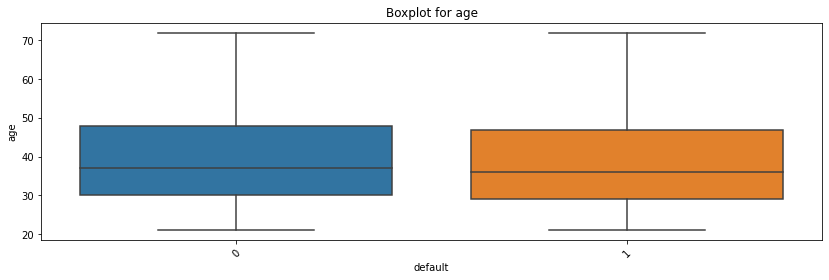

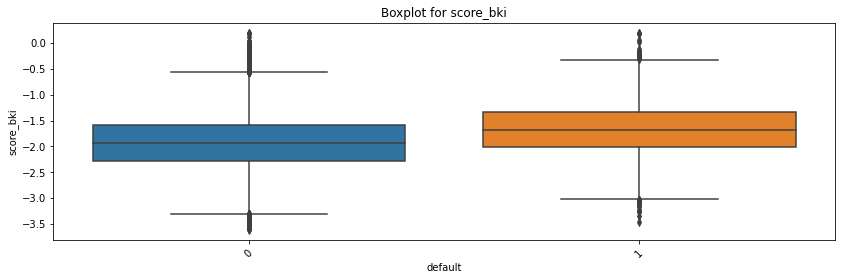

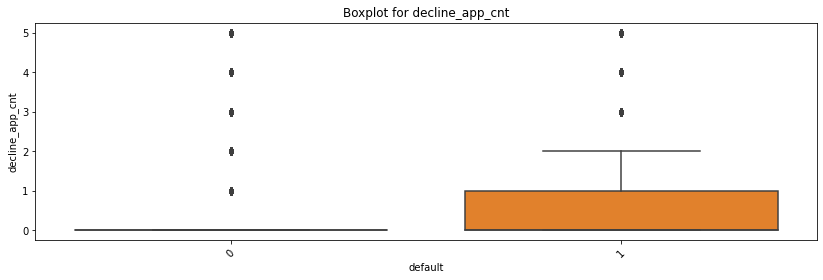

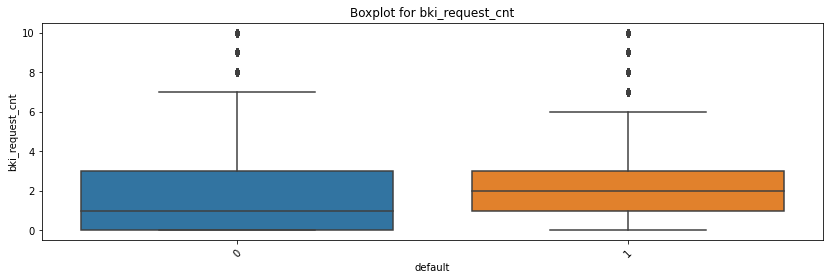

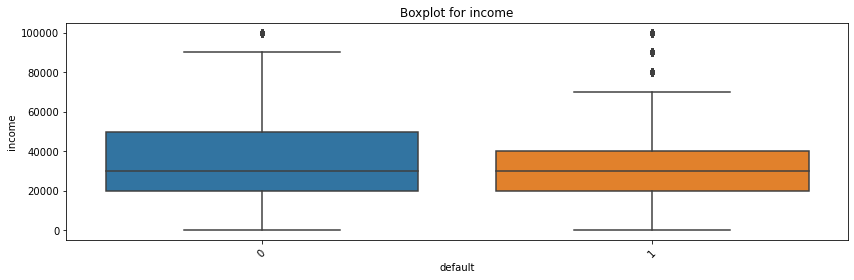

In [51]:
# Построим коробки с усами для численных переменных

# функция построения диаграмм типа коробки с усами
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=column, 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    
for col in num_cols:
    get_boxplot(col)

<AxesSubplot:>

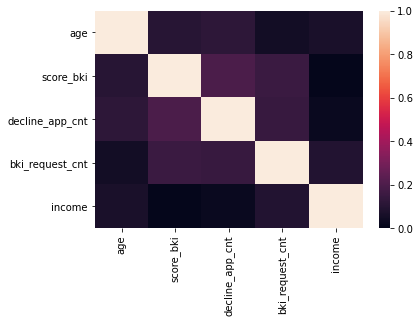

In [52]:
# оценим корреляцию Пирсона, проверим, чтобы между нецелевыми параметрами не было сильных зависимостей
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)
# наиболее ощутимая корреляция рейтинга БКИ и количества отказов, что логично. Сильных линейных связей не видно, значит можно отсавить все признаки

In [53]:
# посмотрим на цифры корреляции в числовом выражении
dct = {}
for i in range(len(num_cols)):
    for k in range(len(num_cols)):
        if i < k:
            dct[num_cols[i],num_cols[k]] = df[[num_cols[i],num_cols[k]]].corr().iloc[0, 1]
dct

{('age', 'score_bki'): -0.10468204702412096,
 ('age', 'decline_app_cnt'): -0.11809770816561284,
 ('age', 'bki_request_cnt'): 0.04975710819265294,
 ('age', 'income'): -0.06805546150396274,
 ('score_bki', 'decline_app_cnt'): 0.1979140244109108,
 ('score_bki', 'bki_request_cnt'): 0.1551761360250093,
 ('score_bki', 'income'): -0.008656210380797712,
 ('decline_app_cnt', 'bki_request_cnt'): 0.14786042475068475,
 ('decline_app_cnt', 'income'): -0.024854285780536063,
 ('bki_request_cnt', 'income'): 0.09091893898541818}

In [54]:
# оценим корреляцию числовых переменных с целевой переменной default
dctDef = {}
for k in range(len(num_cols)):
    dctDef['default',num_cols[k]] = df[['default',num_cols[k]]].corr().iloc[0, 1]
dctDef
# все линейные зависимости оценены как слабые

{('default', 'age'): -0.01916936543015258,
 ('default', 'score_bki'): 0.1397767949009714,
 ('default', 'decline_app_cnt'): 0.09720511101607544,
 ('default', 'bki_request_cnt'): 0.06136522783208311,
 ('default', 'income'): -0.04667542354971297}

<AxesSubplot:>

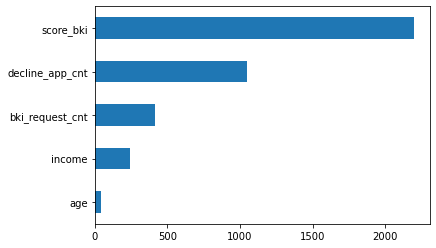

In [55]:
# Оценим значимость числовых переменных
'''В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.'''
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
# наиболее значимым фактором определён score_bki (не зря они едят свой хлеб), по итогам изучения параметр не требует отдельных преобразований

In [56]:
f_classif(df[num_cols], df['default'])
# пояснение от Sergey3011 
# Если вкратце, ты задействуешь для признаков в num_cols однофакторный дисперсионный анализ типа ANOVA. Фактором является целевая переменная.
# В первой строке массива - значения критерия Фишера (да простят меня статистики), во- второй строке - величина p-value для нулевой гипотезы.
# Общий вывод на основе результата: нулевая гипотеза отвергается очень-очень.

(array([  40.48963114, 2194.86554647, 1050.67891681,  416.34364306,
         240.48746772]),
 array([1.98434995e-010, 0.00000000e+000, 2.09952796e-229, 2.26235219e-092,
        3.51410435e-054]))

In [57]:
df.education.value_counts()
# SCH - school - те, у кого среднее образование (только школа).
# UGR - undergraduate - бакалавры.
# GRD - магистры
# PGR - postgraduate - учёная степень PhD (кандидаты наук по-нашему)
# ACD - высший уровень. Можно считать высшей категорией.
# Таким образом, если упорядочить по возрастанию уровня образования, получим следующий список:
# SCH, UGR, GRD, PGR, ACD

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [58]:
# преобразуем коды образования в числовую шкалу
ed_class = ['SCH','UGR','GRD','PGR','ACD']
ed_num = [1,2,3,4,5]
df.education.replace(ed_class, ed_num, inplace = True)

In [59]:
df.sex.value_counts()

F    61836
M    48312
Name: sex, dtype: int64

In [60]:
# Для бинарных признаков мы будем использовать LabelEncoder, он преобразует значения в понятные компьютеру 0 и 1
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    print(column,dict(enumerate(label_encoder.classes_))) # отобразим справочники сделанных кодировок
    
# убедимся в преобразовании    
df.head()

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}
foreign_passport {0: 'N', 1: 'Y'}


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,3,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,1,0,39,0,0,5,0,-1.504999,2,50,1,2,0,4,3,0,0,0
2,75683,23MAR2014,2,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,1,1,56,0,0,0,0,-2.374182,1,40,1,2,20000,1,3,0,0,0
4,28862,04FEB2014,3,0,38,0,0,0,0,-2.487502,0,80,2,3,100000,1,3,0,0,0


<AxesSubplot:>

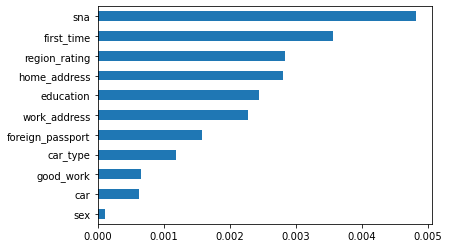

In [61]:
'''Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.'''
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [66]:
# рассмотрим параметр связи заёмщика с клиентами банка
# нам не даётся подробной расшифровки о том что это - рекомендации, поручители, родственные связи и т.д. тем не менее фактор разделён на 4 категории, которые скорее всего выстроены с учётом иерархии ввиду столь сильного влияния фактора на результат. Будем использовать признак как есть, без преобразования в dummy-переменные
df.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

<AxesSubplot:xlabel='sna'>

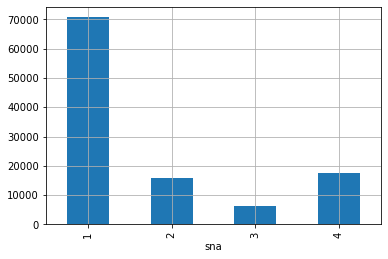

In [74]:
df.groupby(by = ['sna'])['default'].count().plot(kind = 'bar', grid= True) # распределение по количеству

<AxesSubplot:xlabel='sna'>

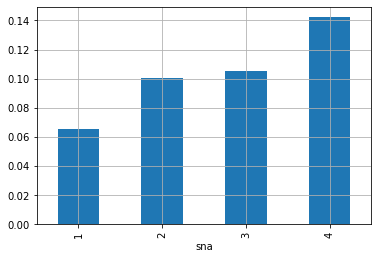

In [75]:
# распределение по доле дефолта
df.groupby(by = ['sna'])['default'].mean().plot(kind = 'bar', grid= True) 

In [64]:
# рассмотрим параметр давности заёмщика как клиента банка
# видим, что данные удобно классифицированы на 4 категории, скорее всего в их последовательности должна быть связь, поэтому оставим параметр без изменений
df.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

In [67]:
# рассмотрим параметр рейтинга региона
# данные классифицированы по 7 группам. У нас нет информации что это за рейтинг - средний уровень зарплаты, количество населения или площадь территории, однако характерп распределения позволяет предположить, что они классифицированы системно и этот параметр мы оставим без изменений
df.region_rating.value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

<AxesSubplot:xlabel='region_rating'>

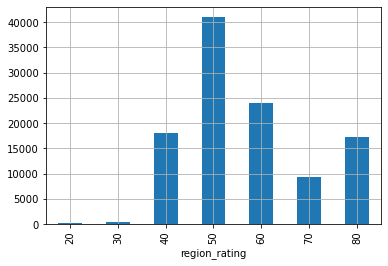

In [72]:
# распределение по количеству
df.groupby(by = ['region_rating'])['default'].count().plot(kind = 'bar', grid= True) 

<AxesSubplot:xlabel='region_rating'>

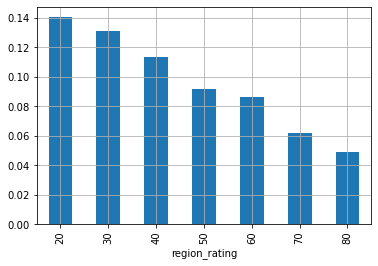

In [73]:
# распределение по доле дефолта
df.groupby(by = ['region_rating'])['default'].mean().plot(kind = 'bar', grid= True)

<AxesSubplot:xlabel='home_address'>

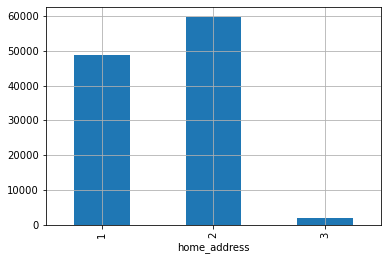

In [76]:
# распределение по количеству
df.groupby(by = ['home_address'])['default'].count().plot(kind = 'bar', grid= True) 

<AxesSubplot:xlabel='home_address'>

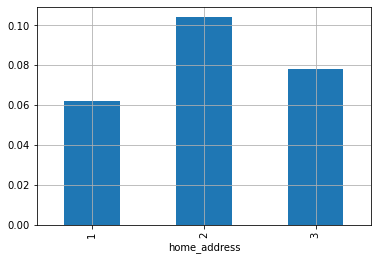

In [77]:
# распределение по доле дефолта
df.groupby(by = ['home_address'])['default'].mean().plot(kind = 'bar', grid= True)

<AxesSubplot:xlabel='work_address'>

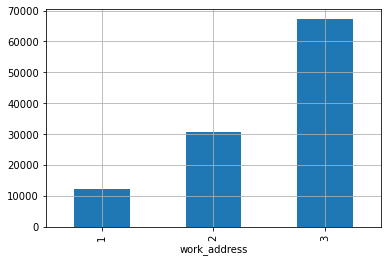

In [78]:
# распределение по количеству
df.groupby(by = ['work_address'])['default'].count().plot(kind = 'bar', grid= True) 

<AxesSubplot:xlabel='work_address'>

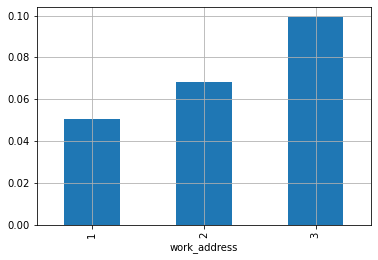

In [79]:
# распределение по доле дефолта
df.groupby(by = ['work_address'])['default'].mean().plot(kind = 'bar', grid= True)

In [80]:
# системности в домашнем адресе не видно, классификация рабочего адреса тоже под сомннеием. 
# решение - преобразуем в дамми-переменные категории домашних и рабочих адресов
df = pd.get_dummies(df, columns = ['home_address','work_address']) 

In [81]:
# Стандартизация числовых переменных, что удобнее для компьютера при обучении
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

In [83]:
# удалим колонки client_id и app_date, т.к. они не могут содержать реальной пользы для обучения и могут только запутать модель
df.drop(['client_id','app_date'], axis=1, inplace=True)

In [84]:
df.sample(2) # посмотрим на итоговый вид преобразованных данных

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time,foreign_passport,sample,default,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3
82704,1,1,1.193834,0,0,-0.372117,0,-0.442935,-0.477126,70,...,3,0,1,0,1,0,0,0,1,0
96945,3,0,-1.323962,1,1,-0.372117,0,1.392949,-0.972840,40,...,3,0,1,0,0,1,0,0,0,1


In [86]:
# Теперь выделим тестовую часть
train = df.query('sample == 1').drop(['sample'], axis=1)
test = df.query('sample == 0').drop(['sample', 'default'], axis=1)

In [87]:
num_0 = len(train[train['default']==0])
num_1 = len(train[train['default']==1])
print(num_0,num_1) # в тренировочной разбивке видим 64427 не дефолтных клиента и 9372 дефолтных

64427 9372


In [88]:
# сбалансируем выборку, чтобы при обучении модель не склонялась к наиболее частому варианту
# случайный оверсэмплинг - увеличиваем количество дефолтных примеров до количества не дефолтных
train = pd.concat([train[train['default']==0] , train[train['default']==1].sample(num_0, replace=True) ])
print(len(train)) 

128854


In [89]:
train.default.value_counts() # количество примеров сравнялось 64427 недефолтных и 64427 дефолтных

1    64427
0    64427
Name: default, dtype: int64

In [96]:
y = train['default'].values  # наш таргет
X = train.drop(['default'], axis=1)

In [98]:
# выделим 20% данных на валидацию (параметр test_size), фиксируем случайность, чтобы сохранить воспроизводимость - random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# проверяем размерность наборов данных
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((103083, 20), (25771, 20), (103083,), (25771,))

In [100]:
# создание и обучение модели логистической регрессии
model = LogisticRegression(solver='liblinear', max_iter=1000).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [101]:
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.67      0.66      0.67     12923
           1       0.66      0.67      0.66     12848

    accuracy                           0.67     25771
   macro avg       0.67      0.67      0.67     25771
weighted avg       0.67      0.67      0.67     25771



In [103]:
confusion_matrix(y_test, y_pred)
# TN FP
# FN TP 

array([[8579, 4344],
       [4287, 8561]], dtype=int64)

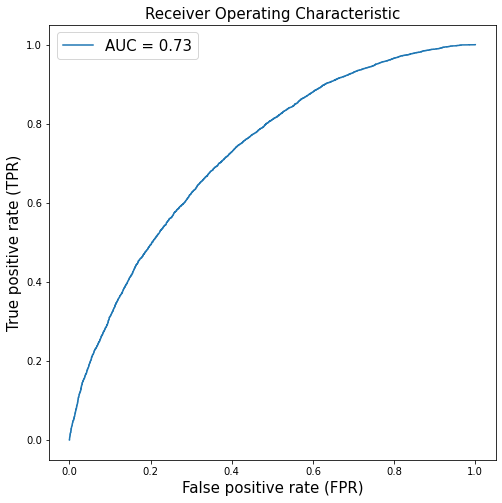

In [104]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]
calc_and_plot_roc(y_test, y_pred_proba)

In [107]:
# сохраняем результаты работы модели и записываем их в итоговый файл 
predict_submission = model.predict(test)
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [110]:
sample_submission.describe() 
# посмотрим результаты прогноза - дефолт предсказан по 37% клиентов

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.373160
std,31706.052195,0.483651
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [115]:
# Автоматический поиск лучших параметров для модели не дал улучшения результата, поэтому он приведён ниже справочно.
'''
# Запустим автоматический поиск наилучших параметров для модели
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
'''

"\n# Запустим автоматический поиск наилучших параметров для модели\n# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3\n# чтобы получить оптимальные параметры модели в первом приближении\nmodel = LogisticRegression()\n\niter_ = 50\nepsilon_stop = 1e-3\n\nparam_grid = [\n    {'penalty': ['l1'], \n     'solver': ['liblinear', 'lbfgs'], \n     'class_weight':['none', 'balanced'], \n     'multi_class': ['auto','ovr'], \n     'max_iter':[iter_],\n     'tol':[epsilon_stop]},\n    {'penalty': ['l2'], \n     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], \n     'class_weight':['none', 'balanced'], \n     'multi_class': ['auto','ovr'], \n     'max_iter':[iter_],\n     'tol':[epsilon_stop]},\n    {'penalty': ['none'], \n     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], \n     'class_weight':['none', 'balanced'], \n     'multi_class': ['auto','ovr'], \n     'max_iter':[iter_],\n     'tol':[epsilon_stop]},\n]\n\n## mod

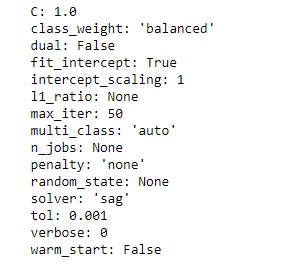

In [113]:
# создание и обучение модели логистической регрессии
model = LogisticRegression(C = 1.0, class_weight = 'balanced', dual = False, fit_intercept = True, intercept_scaling = 1, l1_ratio = None, max_iter = 1000, multi_class = 'auto', n_jobs = None, penalty = 'none', random_state = None, solver = 'sag', tol = 0.001, verbose = 0, warm_start = False).fit(X_train, y_train)
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)
# TN FP
# FN TP 

array([[8560, 4363],
       [4287, 8561]], dtype=int64)

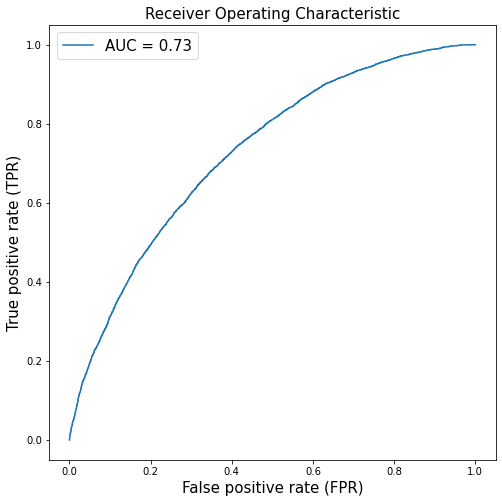

In [114]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]
calc_and_plot_roc(y_test, y_pred_proba)

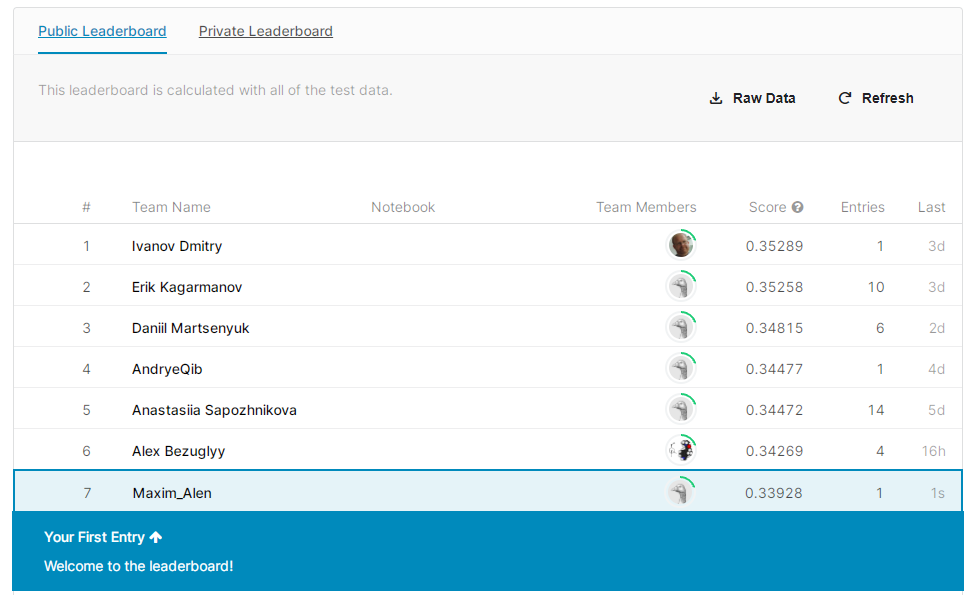